In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique = processed_df[col].unique()
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else:
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. Original unique: {original_unique}, New unique: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns: # Check if column exists BEFORE trying to process
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric.")
                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' for float processing (in FLOAT_PRECISIONS) not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique():
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD, skipping ADV_RATE=0 assignment.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,
    'discovery_quality': 1,
    'FINAL_MAIN_ACC': 4,
    'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3,
    'BENIGN_PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_ADVERSARY_SELECTION_RATE': 3,
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3,
    'COST_OF_CONVERGENCE': 0,
    'TOTAL_COST': 0,
    # --- ADD THESE NEW COLUMNS HERE ---
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {'single': 'Backdoor', np.nan: 'No Attack', 'None': 'No Attack'},
    'IS_SYBIL': { # Example mapping if raw data is boolean
        True: 'mimic', 
        False: 'False' # Or 'Standard' if you prefer that label
    }
}
# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame()

try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=True
    )
    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty:
        print("\nFirst 5 rows of processed summary_df_avg:")
        display(summary_df_avg)
        print("\nInfo of processed summary_df_avg:")
        summary_df_avg.info()
except FileNotFoundError:
    print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}. Cannot proceed with plotting.")
except Exception as e:
    print(f"CRITICAL ERROR: An error occurred during summary_df_avg loading or preprocessing: {e}")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification (Post-Preprocessing) ---")
    check_cols = [
        'AGGREGATION_METHOD', 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE',
        'BENIGN_PAYMENT_GINI_COEFFICIENT',
        'AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3', 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    ]
    for col in check_cols:
        if col in summary_df_avg.columns:
            unique_vals = summary_df_avg[col].unique()
            try:
                if pd.api.types.is_numeric_dtype(summary_df_avg[col].dtype) and not summary_df_avg[col].empty:
                    # Filter out NaNs before sorting for numeric types if they cause issues
                    valid_numeric_vals = summary_df_avg[col].dropna().unique()
                    unique_vals = sorted(list(valid_numeric_vals))
                elif not summary_df_avg[col].empty:
                    unique_vals = sorted(list(map(str,unique_vals))) # Convert to string for robust sorting
            except TypeError:
                 print(f"    (Could not sort unique values for {col} due to mixed types or NaNs)")
                 pass # Cannot sort mixed types further than unique() if NaNs present and not handled
            print(f"Unique values in '{col}': {unique_vals}")
            print(f"  NaNs in '{col}': {summary_df_avg[col].isna().sum()}")
        else:
            print(f"VERIFICATION WARNING: Column '{col}' NOT FOUND in processed summary_df_avg.")
else:
    print("\nsummary_df_avg is empty. Verification skipped. Subsequent plots will likely fail.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' mapped. Original unique: ['single' nan], New unique: ['Backdoor' 'No Attack']
Column 'IS_SYBIL' mapped. Original unique: ['False' 'mimic'], New unique: ['False' 'mimic']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 0
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Column 'PAYMENT_GINI_COEFFICIENT' rounded. NaNs after rounding: 0
Processing float column: AVG_ADVERSARY_SELECTION_RATE with precision 3
  Column 'AVG_ADVERSARY_SELECTION_RATE' rounded. NaNs after rounding: 0
Processing float column: AVG_BENIGN_SELLER_SELE

,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,COC_TARGET_REACHED_ROUND,PAYMENT_GINI_COEFFICIENT,TOTAL_COST,TOTAL_ROUNDS,AVG_BENIGN_SELLER_SELECTION_RATE,AVG_BENIGN_PAYMENT_GINI,NO_ATTACK_DESIG_MAL_SEL_RATE_0.1,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,8.666667,0.122,934.0,61.666667,0.565,0.623172,NaN,NaN,NaN,NaN
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,11.800000,0.143,1141.0,71.400000,0.605,0.600841,NaN,NaN,NaN,NaN
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,8.250000,0.146,874.0,59.000000,0.525,0.633358,NaN,NaN,NaN,NaN
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,10.400000,0.121,970.0,61.300000,0.578,0.603829,NaN,NaN,NaN,NaN
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,4.000000,0.242,316.0,26.000000,0.341,0.615042,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,martfl,discovery,0.1,biased,30.0,No Attack,0.0,mimic,0.0,...,12.000000,0.059,1213.0,70.300000,0.583,0.637386,0.097,0.193,0.295,0.397
182,3,martfl,discovery,1.0,random,30.0,No Attack,0.0,mimic,0.0,...,8.250000,0.135,1047.0,62.500000,0.515,0.669528,0.114,0.221,0.327,0.438
183,9,martfl,discovery,1.0,biased,30.0,No Attack,0.0,mimic,0.0,...,11.000000,0.079,1040.0,63.200000,0.554,0.657056,0.104,0.206,0.303,0.401
184,0,martfl,discovery,10.0,random,30.0,No Attack,0.0,mimic,0.0,...,4.000000,0.321,512.0,42.000000,0.545,0.577207,0.115,0.173,0.206,0.249



Info of processed summary_df_avg:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   run                                     186 non-null    int64  
 1   AGGREGATION_METHOD                      186 non-null    object 
 2   DATA_SPLIT_MODE                         186 non-null    object 
 3   discovery_quality                       186 non-null    float64
 4   buyer_data_mode                         186 non-null    object 
 5   N_CLIENTS                               186 non-null    float64
 6   ATTACK_METHOD                           186 non-null    object 
 7   TRIGGER_RATE                            186 non-null    float64
 8   IS_SYBIL                                186 non-null    object 
 9   ADV_RATE                                186 non-null    float64
 10  CHANGE_BASE                

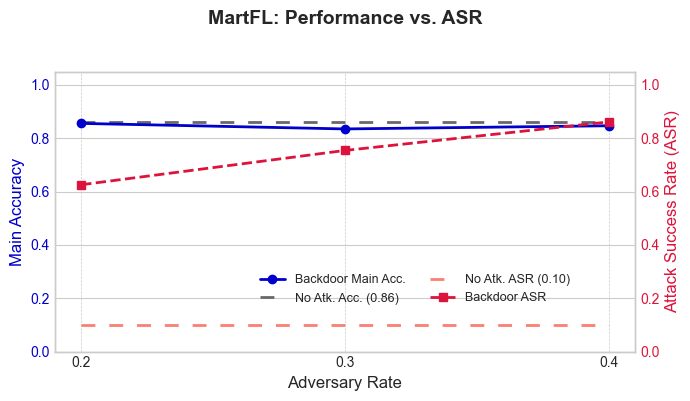

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For custom legend

# --- Assume summary_df_avg is loaded and your PREPROCESSING function is defined and used ---
# summary_df_avg = preprocess_experiment_data(...) # From your previous cell

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy()
    current_aggregation_method = "MartFL"  # Capitalized for title

    no_attack_perf = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_perf.empty:
        no_attack_avg_acc = no_attack_perf['FINAL_MAIN_ACC'].mean()
        no_attack_avg_asr = 0.1  # ASR for No Attack is 0
    else:
        no_attack_avg_acc = np.nan
        no_attack_avg_asr = np.nan

    adv_rates_to_plot_on_x_for_attack = [0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
        ].copy()

    if not backdoor_attack_filtered.empty:
        backdoor_attack_avg_perf = backdoor_attack_filtered.groupby('ADV_RATE', as_index=False)[
            ['FINAL_MAIN_ACC', 'FINAL_ASR']
        ].mean().sort_values(by='ADV_RATE')
        adv_rates_with_backdoor_data = sorted(backdoor_attack_avg_perf['ADV_RATE'].unique())
    else:
        backdoor_attack_avg_perf = pd.DataFrame(columns=['ADV_RATE', 'FINAL_MAIN_ACC', 'FINAL_ASR'])
        adv_rates_with_backdoor_data = []
        print(f"Warning: No 'Backdoor' data found for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")

    # --- Plotting ---
    # Font sizes for paper
    TITLE_FONT_SIZE = 14
    AXIS_LABEL_FONT_SIZE = 12
    TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 9
    LEGEND_TITLE_FONT_SIZE = 10
    LINE_WIDTH = 2.0  # Slightly reduced from 2.5 for typical paper figs
    MARKER_SIZE = 6  # Slightly reduced

    fig, ax1 = plt.subplots(figsize=(7, 4.5))  # Adjusted for paper

    main_acc_color_attack = 'mediumblue'
    asr_color_attack = 'crimson'
    no_attack_acc_color = 'dimgray'  # Changed for better contrast with blue/red
    no_attack_asr_color = 'salmon'  # Changed for better contrast

    legend_elements = []
    x_min_for_no_attack_line = min(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.2
    x_max_for_no_attack_line = max(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.4

    # 1. Plot "No Attack" Main Accuracy
    if pd.notna(no_attack_avg_acc):
        ax1.hlines(y=no_attack_avg_acc, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_acc_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH)  # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_acc_color, linestyle=(0, (5, 5)), lw=LINE_WIDTH,
                                      label=f'No Atk. Acc. ({no_attack_avg_acc:.2f})'))

    # 2. Plot "Backdoor" Main Accuracy
    if not backdoor_attack_avg_perf.empty:
        ax1.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_MAIN_ACC'],
                 color=main_acc_color_attack, linestyle='-', marker='o',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(Line2D([0], [0], color=main_acc_color_attack, linestyle='-', marker='o', lw=LINE_WIDTH,
                                      label='Backdoor Main Acc.'))

    ax1.set_xlabel('Adversary Rate', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.set_ylabel('Main Accuracy', color=main_acc_color_attack, fontsize=AXIS_LABEL_FONT_SIZE)  # Color matches line
    ax1.tick_params(axis='y', labelcolor=main_acc_color_attack, labelsize=TICK_LABEL_FONT_SIZE)
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='y')

    # 3. Second y-axis for ASR
    ax2 = ax1.twinx()

    # 4. Plot "No Attack" ASR
    if pd.notna(no_attack_avg_asr):
        ax2.hlines(y=no_attack_avg_asr, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_asr_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH)  # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_asr_color, linestyle=(0, (5, 5)), lw=LINE_WIDTH,
                                      label=f'No Atk. ASR ({no_attack_avg_asr:.2f})'))

    # 5. Plot "Backdoor" ASR
    if not backdoor_attack_avg_perf.empty:
        ax2.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_ASR'],
                 color=asr_color_attack, linestyle='--', marker='s',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(
            Line2D([0], [0], color=asr_color_attack, linestyle='--', marker='s', lw=LINE_WIDTH, label='Backdoor ASR'))

    ax2.set_ylabel('Attack Success Rate (ASR)', color=asr_color_attack,
                   fontsize=AXIS_LABEL_FONT_SIZE)  # Color matches line
    ax2.tick_params(axis='y', labelcolor=asr_color_attack, labelsize=TICK_LABEL_FONT_SIZE)
    ax2.set_ylim(0, 1.05)

    # 6. X-axis ticks
    if adv_rates_with_backdoor_data:
        ax1.set_xticks(ticks=adv_rates_with_backdoor_data)
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_data], fontsize=TICK_LABEL_FONT_SIZE)
    else:
        ax1.set_xticks(ticks=[0.2, 0.3, 0.4])  # Fallback
        ax1.set_xticklabels(labels=['0.2', '0.3', '0.4'], fontsize=TICK_LABEL_FONT_SIZE)
    ax1.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE)  # Ensure x-tick label size
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')

    # Legend: More compact, 2 columns below plot
    if legend_elements:
        legend_elements.sort(key=lambda x: ("No Attack" not in x.get_label(), "Main Acc" not in x.get_label()))
        fig.legend(handles=legend_elements,
                   title_fontsize=LEGEND_TITLE_FONT_SIZE,
                   fontsize=LEGEND_FONT_SIZE,
                   loc='lower center',  # Place below plot
                   bbox_to_anchor=(0.6, 0.3),  # Adjust y for spacing below x-axis label
                   ncol=2,  # Try 2 columns for 4 items
                   frameon=False)  # Remove legend frame for cleaner look in paper

    fig.suptitle(f'{current_aggregation_method}: Performance vs. ASR', fontsize=TITLE_FONT_SIZE, y=0.98,
                 fontweight='bold')
    plt.tight_layout(
        rect=[0, 0.1, 1, 0.95])  # Adjust rect for suptitle and bottom legend (0.1 at bottom for legend space)
    # plt.savefig(f"{current_aggregation_method}_perf_vs_asr.pdf", bbox_inches='tight') # Example save
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

Plotting averaged 'Backdoor' CoC. ADV_RATEs: [np.float64(0.2), np.float64(0.3), np.float64(0.4)]


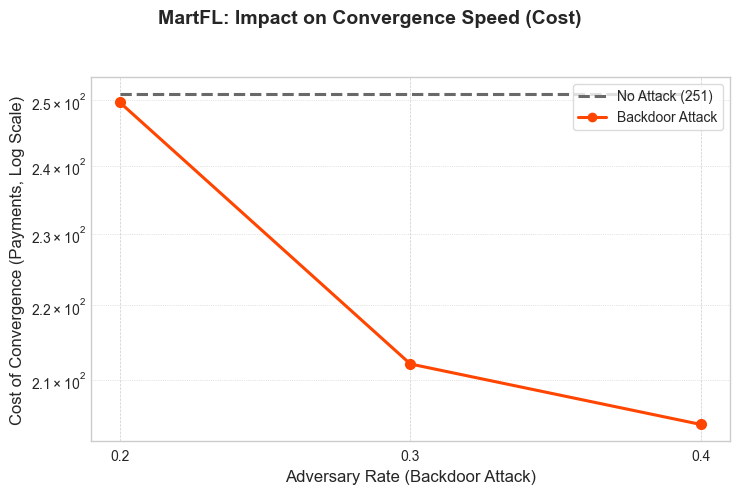

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy() # Assuming it's preprocessed
    current_aggregation_method = "MartFL" # For title

    # Ensure COST_OF_CONVERGENCE_PLOT is ready (handling NaNs as per previous logic)
    if 'COST_OF_CONVERGENCE' in plot_data.columns:
        plot_data['COST_OF_CONVERGENCE'] = pd.to_numeric(plot_data['COST_OF_CONVERGENCE'], errors='coerce')
        if 'TOTAL_COST' in plot_data.columns:
            plot_data['TOTAL_COST'] = pd.to_numeric(plot_data['TOTAL_COST'], errors='coerce')
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE'].fillna(plot_data['TOTAL_COST'])
        else:
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE']
        if plot_data['COST_OF_CONVERGENCE_PLOT'].isna().any():
             print(f"Warning: {plot_data['COST_OF_CONVERGENCE_PLOT'].isna().sum()} NaN CoC values still present.")
    else:
        print("COST_OF_CONVERGENCE column not found. Cannot plot.")
        plot_data['COST_OF_CONVERGENCE_PLOT'] = np.nan # Ensure column exists

    # 1. "No Attack" CoC Baseline (Averaged over IS_SYBIL)
    no_attack_coc_data = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_coc_data.empty:
        # We want a single CoC value for "No Attack" to serve as the baseline
        no_attack_baseline_coc = no_attack_coc_data['COST_OF_CONVERGENCE_PLOT'].mean()
    else:
        no_attack_baseline_coc = np.nan

    # 2. "Backdoor Attack" CoC Data, averaged over IS_SYBIL for each ADV_RATE
    adv_rates_to_plot_on_x_for_attack = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
    ].copy()

    if not backdoor_attack_filtered.empty:
        # Average CoC for "Backdoor" attack at each ADV_RATE (averaging out IS_SYBIL here)
        backdoor_avg_coc_vs_adv_rate = backdoor_attack_filtered.groupby('ADV_RATE', as_index=False)[
            'COST_OF_CONVERGENCE_PLOT'
        ].mean().sort_values(by='ADV_RATE')
        adv_rates_with_backdoor_coc_data = sorted(backdoor_avg_coc_vs_adv_rate['ADV_RATE'].unique())
        print(f"Plotting averaged 'Backdoor' CoC. ADV_RATEs: {adv_rates_with_backdoor_coc_data}")
    else:
        backdoor_avg_coc_vs_adv_rate = pd.DataFrame(columns=['ADV_RATE', 'COST_OF_CONVERGENCE_PLOT'])
        adv_rates_with_backdoor_coc_data = []
        print(f"Warning: No 'Backdoor' CoC data for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")


    # --- Plotting ---
    TITLE_FONT_SIZE = 14
    AXIS_LABEL_FONT_SIZE = 12
    TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 10 # Slightly larger legend text
    # LEGEND_TITLE_FONT_SIZE = 10 # No legend title needed for this simplified version
    LINE_WIDTH = 2.2
    MARKER_SIZE = 7

    fig, ax = plt.subplots(figsize=(7.5, 5)) # Slightly adjusted figsize

    # Colors and styles
    backdoor_coc_color = 'orangered'
    no_attack_coc_color = 'dimgray'

    legend_elements = []

    # 1. Plot "No Attack" CoC as a HORIZONTAL BASELINE LINE
    # Spanning from the first to the last ADV_RATE of the attack data
    if pd.notna(no_attack_baseline_coc) and adv_rates_with_backdoor_coc_data:
        xmin_hline = min(adv_rates_with_backdoor_coc_data)
        xmax_hline = max(adv_rates_with_backdoor_coc_data)
        ax.hlines(y=no_attack_baseline_coc,
                  xmin=xmin_hline, xmax=xmax_hline,
                  color=no_attack_coc_color,
                  linestyle='--', # Dashed line for baseline
                  linewidth=LINE_WIDTH,
                  label=f'No Attack ({no_attack_baseline_coc:.0f})') # For legend
        legend_elements.append(Line2D([0], [0], color=no_attack_coc_color, linestyle='--', lw=LINE_WIDTH, label=f'No Attack ({no_attack_baseline_coc:.0f})'))
    elif pd.notna(no_attack_baseline_coc): # If no attack data, plot as a point at x=0.1 (or another sensible default)
        ax.plot([0.1], [no_attack_baseline_coc], marker='D', markersize=MARKER_SIZE+1, color=no_attack_coc_color, linestyle='None', label=f'No Attack ({no_attack_baseline_coc:.0f})')
        legend_elements.append(Line2D([0], [0], color=no_attack_coc_color, marker='D', markersize=MARKER_SIZE+1, linestyle='None', label=f'No Attack ({no_attack_baseline_coc:.0f})'))


    # 2. Plot "Backdoor Attack" CoC (averaged over IS_SYBIL)
    if not backdoor_avg_coc_vs_adv_rate.empty:
        ax.plot(
            backdoor_avg_coc_vs_adv_rate['ADV_RATE'],
            backdoor_avg_coc_vs_adv_rate['COST_OF_CONVERGENCE_PLOT'],
            color=backdoor_coc_color,
            linestyle='-',
            marker='o',
            linewidth=LINE_WIDTH,
            markersize=MARKER_SIZE,
            label='Backdoor Attack' # For legend
        )
        legend_elements.append(Line2D([0], [0], color=backdoor_coc_color, linestyle='-', marker='o', lw=LINE_WIDTH, label='Backdoor Attack'))

    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel(f'Cost of Convergence (Payments)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)


    # Log Scale for Y-axis (CoC)
    valid_coc_values_plot = pd.concat([
        pd.Series([no_attack_baseline_coc] if pd.notna(no_attack_baseline_coc) else []),
        backdoor_avg_coc_vs_adv_rate['COST_OF_CONVERGENCE_PLOT'] if not backdoor_avg_coc_vs_adv_rate.empty else pd.Series([])
    ]).dropna()

    if not valid_coc_values_plot.empty and (valid_coc_values_plot > 0).all():
        ax.set_yscale('log')
        ax.set_ylabel(f'Cost of Convergence (Payments)', fontsize=AXIS_LABEL_FONT_SIZE)
        # For log scale, ensure y-grid lines are appropriate
        ax.grid(True, which="both", ls=":", linewidth=0.5, axis='y') # Minor ticks for log
    elif not valid_coc_values_plot.empty:
        min_coc_val = valid_coc_values_plot.min()
        ax.set_ylim(bottom=max(0, min_coc_val * 0.8 if pd.notna(min_coc_val) else 0)) # Start y a bit below min
        ax.grid(True, which="major", ls=":", linewidth=0.5, axis='y')
    else:
        ax.grid(True, which="major", ls=":", linewidth=0.5, axis='y')


    # X-axis Ticks: Only show 0.1, 0.2, 0.3, 0.4
    if adv_rates_with_backdoor_coc_data:
        ax.set_xticks(ticks=adv_rates_with_backdoor_coc_data)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_coc_data])
    elif pd.notna(no_attack_baseline_coc) : # If only no_attack_data, show a default x point
        ax.set_xticks(ticks=[0.1]) # Or a sensible single point
        ax.set_xticklabels(labels=['Baseline Ref.'])
    else: # Fallback
        ax.set_xticks(ticks=adv_rates_to_plot_on_x_for_attack)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x_for_attack])

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x') # Grid for x-axis


    # Legend: Simple, 2 items
    if legend_elements:
        ax.legend(handles=legend_elements,
                  fontsize=LEGEND_FONT_SIZE,
                  loc='best', # Let matplotlib decide best location inside plot
                  frameon=True, edgecolor='lightgray') # Add a light frame

    fig.suptitle(f'{current_aggregation_method}: Impact on Convergence Speed (Cost)',
                 fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.94]) # Adjust for suptitle
    # plt.savefig(f"{current_aggregation_method}_coc_speed_impact.pdf", bbox_inches='tight')
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D # For custom legend

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
TARGET_ACCURACY_COC = 0.8 # Used in CoC plot title

# --- Helper Function for Preprocessing (Your existing function) ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    # ... (your preprocess_experiment_data function from the previous response) ...
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy()

    processed_df = df.copy()
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique = processed_df[col].unique()
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else:
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. Original unique: {original_unique}, New unique: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found.")
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns:
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()
                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric.")
                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' for float processing not found.")
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique():
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD, skipping ADV_RATE=0 assignment.")
    return processed_df
    
# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1, 'discovery_quality': 1, 'FINAL_MAIN_ACC': 4, 'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3, 'BENIGN_PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_ADVERSARY_SELECTION_RATE': 3, 
    'AVG_BENIGN_SELLER_SELECTION_RATE': 3,
    'AVG_COST_PER_ROUND': 2, 
    'AVG_COST_PER_ROUND_BENIGN': 2, 
    'AVG_COST_PER_ROUND_MALICIOUS': 2,
    'COST_OF_CONVERGENCE': 0, 'TOTAL_COST': 0,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1': 3, 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2': 3,
    'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3': 3, 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4': 3
}
CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {'single': 'Backdoor', np.nan: 'No Attack', 'None': 'No Attack', 'no_attack': 'No Attack'},
    # IS_SYBIL: Assuming 'False' and 'mimic' are the values from CSV, or add mapping if needed
    # 'IS_SYBIL': {'False': 'Standard', 'mimic': 'Mimic'} # Example to ensure consistent labels
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame()
try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS,
        verbose=False # Set to True for detailed preprocessing logs
    )
    
    # --- DERIVE COST COMPOSITION IF NEEDED (AFTER PREPROCESSING) ---
    # This ensures source columns for derivation are already cleaned (numeric, rounded)
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Check if derivation is needed (i.e., target columns don't exist or are all NaN, but source columns do)
    needs_derivation = False
    if cost_benign_col not in summary_df_avg.columns or summary_df_avg[cost_benign_col].isna().all():
        needs_derivation = True
    if cost_mal_col not in summary_df_avg.columns or summary_df_avg[cost_mal_col].isna().all():
        needs_derivation = True
        
    if needs_derivation and 'AVG_COST_PER_ROUND' in summary_df_avg.columns and \
       'AVG_ADVERSARY_SELECTION_RATE' in summary_df_avg.columns:
        
        print("Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.")
        
        # Ensure source columns are definitely numeric (might be redundant if in FLOAT_PRECISIONS)
        summary_df_avg['AVG_COST_PER_ROUND'] = pd.to_numeric(summary_df_avg['AVG_COST_PER_ROUND'], errors='coerce')
        summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'] = pd.to_numeric(summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'], errors='coerce')

        # For "No Attack" runs, adversary selection rate should be 0 for this calculation
        # The original AVG_ADVERSARY_SELECTION_RATE for "No Attack" runs might be NaN if not set by experiment script
        adv_sel_rate_for_calc = summary_df_avg['AVG_ADVERSARY_SELECTION_RATE'].copy()
        adv_sel_rate_for_calc[summary_df_avg['ATTACK_METHOD'] == 'No Attack'] = 0.0
        adv_sel_rate_for_calc.fillna(0.0, inplace=True) # Fill any remaining NaNs with 0 for calculation

        summary_df_avg[cost_mal_col] = summary_df_avg['AVG_COST_PER_ROUND'] * adv_sel_rate_for_calc
        summary_df_avg[cost_benign_col] = summary_df_avg['AVG_COST_PER_ROUND'] * (1 - adv_sel_rate_for_calc)
        
        # Round the newly derived columns
        summary_df_avg[cost_mal_col] = summary_df_avg[cost_mal_col].round(FLOAT_PRECISIONS.get(cost_mal_col, 2))
        summary_df_avg[cost_benign_col] = summary_df_avg[cost_benign_col].round(FLOAT_PRECISIONS.get(cost_benign_col, 2))
        print("Derived cost composition columns processed.")
        
    if not summary_df_avg.empty: 
        print("\nFirst 5 rows of processed summary_df_avg (after potential derivation):")
        display(summary_df_avg.head())
        # print("\nInfo of processed summary_df_avg:")
        # summary_df_avg.info()

except FileNotFoundError: print(f"CRITICAL ERROR: summary_avg.csv not found in {OUTPUT_DIR}.")
except Exception as e: print(f"CRITICAL ERROR during summary_df_avg loading/preprocessing: {e}")

plt.style.use('seaborn-v0_8-whitegrid'); sns.set_palette("muted")
# ... (Your verification block if you have one) ...

--- Preprocessing summary_avg.csv ---
Deriving cost composition (benign/malicious) from AVG_COST_PER_ROUND and AVG_ADVERSARY_SELECTION_RATE.
Derived cost composition columns processed.

First 5 rows of processed summary_df_avg (after potential derivation):


,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,TOTAL_COST,TOTAL_ROUNDS,AVG_BENIGN_SELLER_SELECTION_RATE,AVG_BENIGN_PAYMENT_GINI,NO_ATTACK_DESIG_MAL_SEL_RATE_0.1,NO_ATTACK_DESIG_MAL_SEL_RATE_0.2,NO_ATTACK_DESIG_MAL_SEL_RATE_0.3,NO_ATTACK_DESIG_MAL_SEL_RATE_0.4,AVG_COST_PER_ROUND_MALICIOUS,AVG_COST_PER_ROUND_BENIGN
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,934.0,61.666667,0.565,0.623172,NaN,NaN,NaN,NaN,1.84,13.40
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,1141.0,71.400000,0.605,0.600841,NaN,NaN,NaN,NaN,1.82,14.17
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,874.0,59.000000,0.525,0.633358,NaN,NaN,NaN,NaN,2.53,12.29
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,970.0,61.300000,0.578,0.603829,NaN,NaN,NaN,NaN,2.54,13.35
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,316.0,26.000000,0.341,0.615042,NaN,NaN,NaN,NaN,5.27,6.88


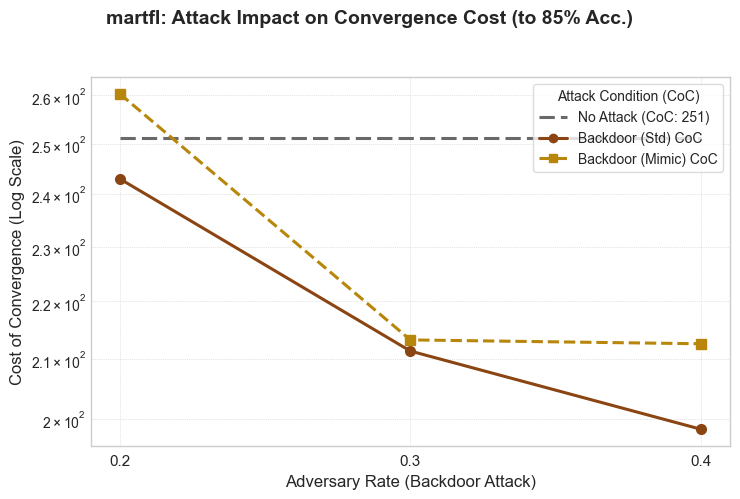

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_coc = summary_df_avg.copy()
    # Assuming AGGREGATION_METHOD is constant or you filter for a specific one
    aggregation_methods_present = plot_data_coc['AGGREGATION_METHOD'].unique()
    current_aggregation_method = aggregation_methods_present[0] if len(aggregation_methods_present) > 0 else "UnknownMethod"
    if len(aggregation_methods_present) > 1:
        print(f"Warning (CoC Plot): Multiple aggregation methods. Plotting for '{current_aggregation_method}'.")
        plot_data_coc = plot_data_coc[plot_data_coc['AGGREGATION_METHOD'] == current_aggregation_method]

    TARGET_ACCURACY_COC = 0.85 # Ensure this matches your experiment setup for the title

    # Ensure COST_OF_CONVERGENCE_PLOT column is ready from Cell 1
    if 'COST_OF_CONVERGENCE_PLOT' not in plot_data_coc.columns:
        if 'COST_OF_CONVERGENCE' in plot_data_coc.columns: # Attempt to create it if base column exists
            plot_data_coc['COST_OF_CONVERGENCE'] = pd.to_numeric(plot_data_coc['COST_OF_CONVERGENCE'], errors='coerce')
            if 'TOTAL_COST' in plot_data_coc.columns:
                 plot_data_coc['TOTAL_COST'] = pd.to_numeric(plot_data_coc['TOTAL_COST'], errors='coerce')
                 plot_data_coc['COST_OF_CONVERGENCE_PLOT'] = plot_data_coc['COST_OF_CONVERGENCE'].fillna(plot_data_coc['TOTAL_COST'])
            else:
                 plot_data_coc['COST_OF_CONVERGENCE_PLOT'] = plot_data_coc['COST_OF_CONVERGENCE']
            plot_data_coc.dropna(subset=['COST_OF_CONVERGENCE_PLOT'], inplace=True)
        else:
            print("Error (CoC Plot): 'COST_OF_CONVERGENCE' or 'COST_OF_CONVERGENCE_PLOT' not found.")
            plot_data_coc = pd.DataFrame() # Prevent plotting

    if not plot_data_coc.empty and 'COST_OF_CONVERGENCE_PLOT' in plot_data_coc.columns and not plot_data_coc['COST_OF_CONVERGENCE_PLOT'].isna().all():
        no_attack_coc_data = plot_data_coc[plot_data_coc['ATTACK_METHOD'] == 'No Attack'].copy()
        no_attack_baseline_coc = no_attack_coc_data['COST_OF_CONVERGENCE_PLOT'].mean() if not no_attack_coc_data.empty else np.nan

        adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
        backdoor_attack_coc_filtered = plot_data_coc[
            (plot_data_coc['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_coc['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        backdoor_coc_by_sybil = pd.DataFrame()
        adv_rates_present_coc = []
        if not backdoor_attack_coc_filtered.empty:
            backdoor_coc_by_sybil = backdoor_attack_coc_filtered.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )['COST_OF_CONVERGENCE_PLOT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_coc = sorted(backdoor_coc_by_sybil['ADV_RATE'].unique())

        # --- Plotting CoC ---
        if not backdoor_coc_by_sybil.empty or pd.notna(no_attack_baseline_coc):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7
            fig, ax = plt.subplots(figsize=(7.5, 5))

            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'saddlebrown', 'Backdoor (Mimic)': 'darkgoldenrod' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
            legend_elements_coc = []

            xmin_hline = min(adv_rates_present_coc) if adv_rates_present_coc else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_coc) if adv_rates_present_coc else max(adv_rates_to_plot_on_x)

            if pd.notna(no_attack_baseline_coc):
                ax.hlines(y=no_attack_baseline_coc, xmin=xmin_hline, xmax=xmax_hline, color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_coc.append(Line2D([0],[0],color=colors['No Attack'],lw=LINE_WIDTH,ls=linestyles['No Attack'],label=f'No Attack (CoC: {no_attack_baseline_coc:.0f})'))
            if not backdoor_coc_by_sybil.empty:
                data_std = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'False'] # Assumes 'False' for Standard
                if not data_std.empty:
                    ax.plot(data_std['ADV_RATE'], data_std['COST_OF_CONVERGENCE_PLOT'], color=colors['Backdoor (Standard)'], marker=markers['Backdoor (Standard)'], ls=linestyles['Backdoor (Standard)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
                    legend_elements_coc.append(Line2D([0],[0],color=colors['Backdoor (Standard)'],lw=LINE_WIDTH,marker=markers['Backdoor (Standard)'],ls=linestyles['Backdoor (Standard)'],label='Backdoor (Std) CoC'))
                data_mimic = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic.empty:
                    ax.plot(data_mimic['ADV_RATE'], data_mimic['COST_OF_CONVERGENCE_PLOT'], color=colors['Backdoor (Mimic)'], marker=markers['Backdoor (Mimic)'], ls=linestyles['Backdoor (Mimic)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
                    legend_elements_coc.append(Line2D([0],[0],color=colors['Backdoor (Mimic)'],lw=LINE_WIDTH,marker=markers['Backdoor (Mimic)'],ls=linestyles['Backdoor (Mimic)'],label='Backdoor (Mimic) CoC'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel(f'Cost of Convergence (Payments)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            
            # Log Scale for CoC
            valid_coc_plot_vals_current = pd.concat([
                pd.Series([no_attack_baseline_coc] if pd.notna(no_attack_baseline_coc) else []),
                backdoor_coc_by_sybil['COST_OF_CONVERGENCE_PLOT'] if not backdoor_coc_by_sybil.empty else pd.Series([])
            ]).dropna()
            if not valid_coc_plot_vals_current.empty and (valid_coc_plot_vals_current > 0).all():
                ax.set_yscale('log'); ax.set_ylabel(f'Cost of Convergence (Log Scale)', fontsize=AXIS_LABEL_FONT_SIZE)
            elif not valid_coc_plot_vals_current.empty :
                min_val = valid_coc_plot_vals_current.min(); ax.set_ylim(bottom=max(0, min_val*0.9 if pd.notna(min_val) else 0))
            
            plot_xticks_coc = adv_rates_present_coc if adv_rates_present_coc else adv_rates_to_plot_on_x
            if plot_xticks_coc: ax.set_xticks(ticks=plot_xticks_coc); ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_coc])
            ax.grid(True, which="both", ls=":", linewidth=0.5)
            if legend_elements_coc:
                ax.legend(handles=legend_elements_coc, title='Attack Condition (CoC)', fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
            fig.suptitle(f'{current_aggregation_method}: Attack Impact on Convergence Cost (to {TARGET_ACCURACY_COC*100:.0f}% Acc.)', fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0,0,1,0.95])
            plt.show()
        else:
            print("Not enough data for CoC plot after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available for CoC plot.")

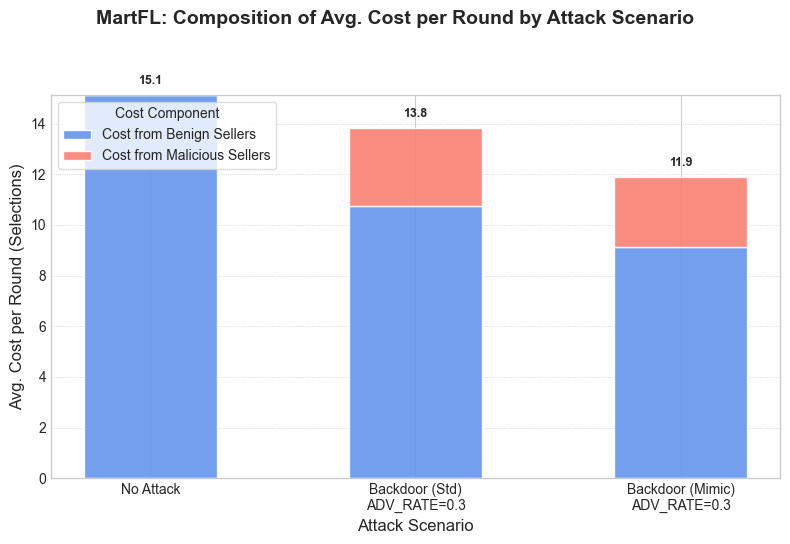

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.
# It requires 'AVG_COST_PER_ROUND_BENIGN' and 'AVG_COST_PER_ROUND_MALICIOUS'
# (which may have been derived in Cell 1).

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_cost_bar = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL'

    # --- Columns needed for cost composition ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    
    # Verify required columns exist and are not all NaN
    if not (cost_benign_col in plot_data_cost_bar.columns and cost_mal_col in plot_data_cost_bar.columns):
        print(f"Error (Cost Bar Plot): Cost composition columns ('{cost_benign_col}', '{cost_mal_col}') not found. Check Cell 1 derivation.")
    elif plot_data_cost_bar[[cost_benign_col, cost_mal_col]].isna().all().all():
        print(f"Error (Cost Bar Plot): Cost composition columns are entirely NaN.")
    else:
        # Ensure columns are numeric (already handled by preprocess_experiment_data if listed in FLOAT_PRECISIONS)
        # Drop rows if either essential cost component is NaN for this plot
        plot_data_cost_bar.dropna(subset=[cost_benign_col, cost_mal_col], how='any', inplace=True)

        # --- Prepare Data for the 3 Scenarios for Bar Chart ---
        # 1. No Attack Scenario (ADV_RATE is 0.0 for these)
        no_attack_cost_data = plot_data_cost_bar[plot_data_cost_bar['ATTACK_METHOD'] == 'No Attack'].copy()
        # Average over IS_SYBIL for a single "No Attack" bar
        avg_no_attack_cost_benign = no_attack_cost_data[cost_benign_col].mean() if not no_attack_cost_data.empty else 0
        avg_no_attack_cost_mal = no_attack_cost_data[cost_mal_col].mean() if not no_attack_cost_data.empty else 0 # Should be 0

        # 2. Backdoor Attack (Standard) - at a specific ADV_RATE
        REPRESENTATIVE_ADV_RATE_FOR_ATTACK = 0.3 # Or choose another representative rate
        
        std_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'False') & # Standard
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_std_backdoor_cost_benign = std_backdoor_data[cost_benign_col].mean() if not std_backdoor_data.empty else 0
        avg_std_backdoor_cost_mal = std_backdoor_data[cost_mal_col].mean() if not std_backdoor_data.empty else 0

        # 3. Backdoor Attack (Mimic) - at the same representative ADV_RATE
        mimic_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'mimic') &
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_mimic_backdoor_cost_benign = mimic_backdoor_data[cost_benign_col].mean() if not mimic_backdoor_data.empty else 0
        avg_mimic_backdoor_cost_mal = mimic_backdoor_data[cost_mal_col].mean() if not mimic_backdoor_data.empty else 0

        # --- Data for Bar Chart ---
        scenarios = ['No Attack', f'Backdoor (Std)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}', 
                     f'Backdoor (Mimic)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}']
        benign_costs = [avg_no_attack_cost_benign, avg_std_backdoor_cost_benign, avg_mimic_backdoor_cost_benign]
        malicious_costs = [avg_no_attack_cost_mal, avg_std_backdoor_cost_mal, avg_mimic_backdoor_cost_mal]

        # --- Plotting Stacked Bar Chart ---
        if any(pd.notna(c) for c in benign_costs + malicious_costs) and any(c > 0 for c in benign_costs + malicious_costs):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 10 # Reduced x-tick for long labels
            LEGEND_FONT_SIZE = 10; BAR_WIDTH = 0.5 # Adjusted bar width

            fig, ax = plt.subplots(figsize=(8, 5.5))

            x_pos = np.arange(len(scenarios))

            bar1 = ax.bar(x_pos, benign_costs, BAR_WIDTH, label='Cost from Benign Sellers', color='cornflowerblue', alpha=0.9)
            bar2 = ax.bar(x_pos, malicious_costs, BAR_WIDTH, bottom=benign_costs, label='Cost from Malicious Sellers', color='salmon', alpha=0.9)

            ax.set_xlabel('Attack Scenario', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Avg. Cost per Round (Selections)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
            
            ax.set_xticks(x_pos)
            ax.set_xticklabels(scenarios, rotation=0, ha="center", fontsize=TICK_LABEL_FONT_SIZE)

            # Add values on top of bars for total cost
            for i in range(len(x_pos)):
                total_height = (benign_costs[i] if pd.notna(benign_costs[i]) else 0) + \
                               (malicious_costs[i] if pd.notna(malicious_costs[i]) else 0)
                if total_height > 0: # Only add text if bar has height
                     ax.text(x_pos[i], total_height + 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]), # Position above bar
                            f'{total_height:.1f}', ha='center', va='bottom', fontsize=TICK_LABEL_FONT_SIZE-1, fontweight='bold')

            ax.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y'); ax.set_axisbelow(True)
            ax.legend(title='Cost Component', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE, loc='upper left', frameon=True, edgecolor='lightgray')
            fig.suptitle(f'{current_aggregation_method}: Composition of Avg. Cost per Round by Attack Scenario', fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Not enough data to plot Cost Composition bar chart after filtering for specific scenarios.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping Cost Composition plot.")

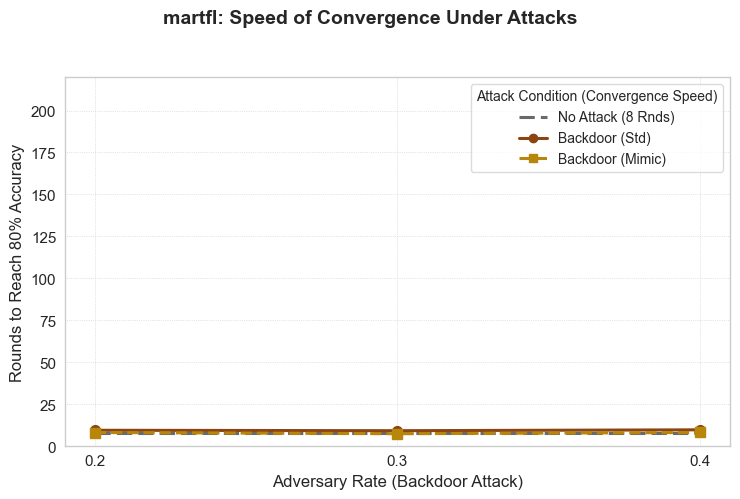

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in a previous cell (Cell 1).
# It requires the 'COC_TARGET_REACHED_ROUND' column.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_rounds = summary_df_avg.copy()
    # Assuming AGGREGATION_METHOD is constant or you filter for a specific one
    aggregation_methods_present = plot_data_rounds['AGGREGATION_METHOD'].unique()
    current_aggregation_method = aggregation_methods_present[0] if len(aggregation_methods_present) > 0 else "UnknownMethod"
    TARGET_ACCURACY_COC = 0.8 # For the title, ensure this matches your experiment

    if len(aggregation_methods_present) > 1:
        print(f"Warning (Rounds to Converge Plot): Multiple aggregation methods. Plotting for '{current_aggregation_method}'.")
        plot_data_rounds = plot_data_rounds[plot_data_rounds['AGGREGATION_METHOD'] == current_aggregation_method]

    # Ensure COC_TARGET_REACHED_ROUND is numeric and handle NaNs
    # NaNs in this column mean the target accuracy was NOT reached.
    # For plotting, we might replace NaNs with a very high number (e.g., max rounds + penalty)
    # or simply let them be missing from the plot lines.
    # Let's assume your experiment runs for a MAX_TOTAL_ROUNDS (e.g., 200 from your paper text)
    MAX_EXPERIMENTAL_ROUNDS = 200 # Define this based on your experiment setup
    
    if 'COC_TARGET_REACHED_ROUND' not in plot_data_rounds.columns:
        print("Error (Rounds to Converge Plot): 'COC_TARGET_REACHED_ROUND' column not found.")
    elif plot_data_rounds['COC_TARGET_REACHED_ROUND'].isna().all():
        print("Error (Rounds to Converge Plot): 'COC_TARGET_REACHED_ROUND' column is all NaN.")
    else:
        plot_data_rounds['COC_TARGET_REACHED_ROUND_PLOT'] = pd.to_numeric(plot_data_rounds['COC_TARGET_REACHED_ROUND'], errors='coerce')
        
        # Handle cases where convergence was not met
        # Option 1: Plot as MAX_EXPERIMENTAL_ROUNDS + a small amount to indicate non-convergence
        # plot_data_rounds['COC_TARGET_REACHED_ROUND_PLOT'].fillna(MAX_EXPERIMENTAL_ROUNDS + 10, inplace=True)
        # Option 2: Let NaNs be, and lines will break (often preferred to avoid misrepresentation)
        # For this plot, let's use Option 2 and let NaNs break lines. We can note non-convergence.

        # 1. "No Attack" Rounds to Converge Baseline (Averaged over IS_SYBIL)
        no_attack_rounds_data = plot_data_rounds[plot_data_rounds['ATTACK_METHOD'] == 'No Attack'].copy()
        no_attack_baseline_rounds = no_attack_rounds_data['COC_TARGET_REACHED_ROUND_PLOT'].mean() if not no_attack_rounds_data.empty else np.nan

        # 2. "Backdoor Attack" Rounds to Converge Data, distinguishing IS_SYBIL
        adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4] # Ensure these match your CoC plot x-axis
        backdoor_attack_rounds_filtered = plot_data_rounds[
            (plot_data_rounds['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_rounds['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        backdoor_rounds_by_sybil = pd.DataFrame()
        adv_rates_present_rounds = []
        if not backdoor_attack_rounds_filtered.empty:
            backdoor_rounds_by_sybil = backdoor_attack_rounds_filtered.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )['COC_TARGET_REACHED_ROUND_PLOT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_rounds = sorted(backdoor_rounds_by_sybil['ADV_RATE'].unique())


        # --- Plotting Rounds to Converge ---
        if not backdoor_rounds_by_sybil.empty or pd.notna(no_attack_baseline_rounds):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7
            fig, ax = plt.subplots(figsize=(7.5, 5)) # Consistent figsize

            # Use same colors/styles as CoC plot for consistency
            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'saddlebrown', 'Backdoor (Mimic)': 'darkgoldenrod' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
            legend_elements_rounds = []

            xmin_hline = min(adv_rates_present_rounds) if adv_rates_present_rounds else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_rounds) if adv_rates_present_rounds else max(adv_rates_to_plot_on_x)

            # Plot "No Attack" Rounds Baseline
            if pd.notna(no_attack_baseline_rounds):
                ax.hlines(y=no_attack_baseline_rounds, xmin=xmin_hline, xmax=xmax_hline,
                          color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_rounds.append(Line2D([0],[0],color=colors['No Attack'],lw=LINE_WIDTH,
                                                  ls=linestyles['No Attack'],label=f'No Attack ({no_attack_baseline_rounds:.0f} Rnds)'))

            # Plot "Backdoor Attack" Rounds
            if not backdoor_rounds_by_sybil.empty:
                # Standard Backdoor (IS_SYBIL='False')
                data_std_rounds = backdoor_rounds_by_sybil[backdoor_rounds_by_sybil['IS_SYBIL'] == 'False']
                if not data_std_rounds.empty:
                    ax.plot(data_std_rounds['ADV_RATE'], data_std_rounds['COC_TARGET_REACHED_ROUND_PLOT'],
                            color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                            marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_rounds.append(Line2D([0],[0],color=colors['Backdoor (Standard)'],lw=LINE_WIDTH,
                                                      marker=markers['Backdoor (Standard)'],ls=linestyles['Backdoor (Standard)'],
                                                      label='Backdoor (Std)'))
                # Mimic Backdoor (IS_SYBIL='mimic')
                data_mimic_rounds = backdoor_rounds_by_sybil[backdoor_rounds_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic_rounds.empty:
                    ax.plot(data_mimic_rounds['ADV_RATE'], data_mimic_rounds['COC_TARGET_REACHED_ROUND_PLOT'],
                            color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                            marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_rounds.append(Line2D([0],[0],color=colors['Backdoor (Mimic)'],lw=LINE_WIDTH,
                                                      marker=markers['Backdoor (Mimic)'],ls=linestyles['Backdoor (Mimic)'],
                                                      label='Backdoor (Mimic)'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel(f'Rounds to Reach {TARGET_ACCURACY_COC*100:.0f}% Accuracy', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            # Y-axis limit might need adjustment based on your data range, e.g., up to MAX_EXPERIMENTAL_ROUNDS
            ax.set_ylim(bottom=0, top=MAX_EXPERIMENTAL_ROUNDS * 1.1 if pd.notna(plot_data_rounds['COC_TARGET_REACHED_ROUND_PLOT'].max()) else MAX_EXPERIMENTAL_ROUNDS) 
            
            plot_xticks_rounds = adv_rates_present_rounds if adv_rates_present_rounds else adv_rates_to_plot_on_x
            if plot_xticks_rounds:
                 ax.set_xticks(ticks=plot_xticks_rounds)
                 ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_rounds])
            
            ax.grid(True, which="major", ls=":", linewidth=0.5)
            if legend_elements_rounds:
                ax.legend(handles=legend_elements_rounds, title='Attack Condition (Convergence Speed)',
                          fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
            fig.suptitle(f'{current_aggregation_method}: Speed of Convergence Under Attacks',
                         fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0,0,1,0.95])
            # plt.savefig(f"{current_aggregation_method}_rounds_to_converge.pdf", bbox_inches='tight')
            plt.show()
        else:
            print("Not enough data for Rounds to Converge plot after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available for Rounds to Converge plot.")

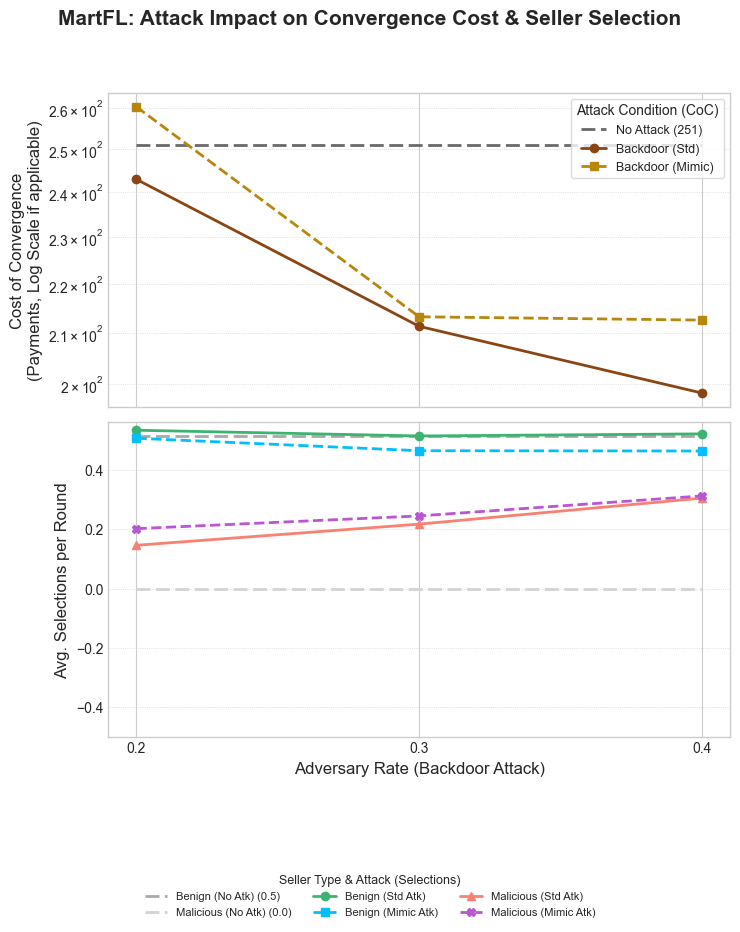

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn might not be used directly here but good to have
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED from Cell 1 ---
# It needs: COST_OF_CONVERGENCE_PLOT, TOTAL_COST (for CoC NaN handling),
#           ATTACK_METHOD, IS_SYBIL, ADV_RATE,
#           AVG_BENIGN_SELLER_SELECTION_RATE, AVG_ADVERSARY_SELECTION_RATE

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # For titles
    TARGET_ACCURACY_COC = 0.8 # Assuming this was used for CoC calculation

    # --- Ensure necessary columns are numeric and handle NaNs for CoC plot ---
    if 'COST_OF_CONVERGENCE' in plot_data.columns:
        plot_data['COST_OF_CONVERGENCE'] = pd.to_numeric(plot_data['COST_OF_CONVERGENCE'], errors='coerce')
        if 'TOTAL_COST' in plot_data.columns: # Use TOTAL_COST if CoC is NaN (target not met)
            plot_data['TOTAL_COST'] = pd.to_numeric(plot_data['TOTAL_COST'], errors='coerce')
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE'].fillna(plot_data['TOTAL_COST'])
        else:
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE']
        plot_data.dropna(subset=['COST_OF_CONVERGENCE_PLOT'], inplace=True) # Drop if still NaN
    else:
        print("Error: 'COST_OF_CONVERGENCE' column missing for CoC plot.")
        plot_data['COST_OF_CONVERGENCE_PLOT'] = np.nan # Create to avoid error

    # --- Ensure necessary columns are numeric for Selection Rate plot ---
    selection_rate_cols = ['AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE']
    missing_sr_cols = [col for col in selection_rate_cols if col not in plot_data.columns]
    if missing_sr_cols:
        print(f"Error: Selection rate columns missing: {missing_sr_cols}. Cannot plot selection rates.")
    else:
        for col in selection_rate_cols:
            plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')
        plot_data.dropna(subset=selection_rate_cols, how='any', inplace=True)


    # --- Data Preparation for CoC Plot ---
    # 1. "No Attack" CoC Baseline (Averaged over IS_SYBIL)
    no_attack_coc_data = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    no_attack_baseline_coc = no_attack_coc_data['COST_OF_CONVERGENCE_PLOT'].mean() if not no_attack_coc_data.empty else np.nan

    # 2. "Backdoor Attack" CoC Data, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_coc_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    backdoor_coc_by_sybil = pd.DataFrame() # Initialize
    adv_rates_present_coc = []
    if not backdoor_attack_coc_filtered.empty:
        backdoor_coc_by_sybil = backdoor_attack_coc_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )['COST_OF_CONVERGENCE_PLOT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_coc = sorted(backdoor_coc_by_sybil['ADV_RATE'].unique())


    # --- Data Preparation for Selection Rate Plot ---
    # 1. "No Attack" Selection Rate Baselines (Averaged over IS_SYBIL)
    no_attack_avg_benign_select = no_attack_coc_data['AVG_BENIGN_SELLER_SELECTION_RATE'].mean() if not no_attack_coc_data.empty and 'AVG_BENIGN_SELLER_SELECTION_RATE' in no_attack_coc_data else np.nan
    no_attack_avg_mal_select = 0.0 # Malicious selected should be 0 for no attack

    # 2. "Backdoor Attack" Selection Rates, distinguishing IS_SYBIL
    backdoor_select_by_sybil = pd.DataFrame() # Initialize
    adv_rates_present_sel = []
    if not backdoor_attack_coc_filtered.empty and all(col in backdoor_attack_coc_filtered for col in selection_rate_cols): # Use same filtered data
        backdoor_select_by_sybil = backdoor_attack_coc_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )[selection_rate_cols].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_sel = sorted(backdoor_select_by_sybil['ADV_RATE'].unique())


    # --- Plotting (2 Panels) ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 9; LEGEND_TITLE_FONT_SIZE = 10
    LINE_WIDTH = 2.0; MARKER_SIZE = 6

    fig, axes = plt.subplots(2, 1, figsize=(7.5, 8.5), sharex=True) # 2 rows, 1 col, shared x-axis

    # Panel 1: Cost of Convergence
    ax_coc = axes[0]
    coc_colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'saddlebrown', 'Backdoor (Mimic)': 'darkgoldenrod' }
    coc_linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
    coc_markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
    legend_elements_coc = []

    xmin_hline_coc = min(adv_rates_present_coc) if adv_rates_present_coc else min(adv_rates_to_plot_on_x)
    xmax_hline_coc = max(adv_rates_present_coc) if adv_rates_present_coc else max(adv_rates_to_plot_on_x)

    if pd.notna(no_attack_baseline_coc):
        ax_coc.hlines(y=no_attack_baseline_coc, xmin=xmin_hline_coc, xmax=xmax_hline_coc,
                      color=coc_colors['No Attack'], linestyle=coc_linestyles['No Attack'], linewidth=LINE_WIDTH)
        legend_elements_coc.append(Line2D([0],[0], color=coc_colors['No Attack'], linestyle=coc_linestyles['No Attack'],
                                          lw=LINE_WIDTH, label=f'No Attack ({no_attack_baseline_coc:.0f})'))
    if not backdoor_coc_by_sybil.empty:
        data_std_coc = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'False']
        if not data_std_coc.empty:
            ax_coc.plot(data_std_coc['ADV_RATE'], data_std_coc['COST_OF_CONVERGENCE_PLOT'],
                        color=coc_colors['Backdoor (Standard)'], linestyle=coc_linestyles['Backdoor (Standard)'],
                        marker=coc_markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements_coc.append(Line2D([0],[0],color=coc_colors['Backdoor (Standard)'],lw=LINE_WIDTH,marker=coc_markers['Backdoor (Standard)'],linestyle=coc_linestyles['Backdoor (Standard)'],label='Backdoor (Std)'))
        data_mimic_coc = backdoor_coc_by_sybil[backdoor_coc_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic_coc.empty:
            ax_coc.plot(data_mimic_coc['ADV_RATE'], data_mimic_coc['COST_OF_CONVERGENCE_PLOT'],
                        color=coc_colors['Backdoor (Mimic)'], linestyle=coc_linestyles['Backdoor (Mimic)'],
                        marker=coc_markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements_coc.append(Line2D([0],[0],color=coc_colors['Backdoor (Mimic)'],lw=LINE_WIDTH,marker=coc_markers['Backdoor (Mimic)'],linestyle=coc_linestyles['Backdoor (Mimic)'],label='Backdoor (Mimic)'))

    ax_coc.set_ylabel(f'Cost of Convergence\n(Payments, Log Scale if applicable)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax_coc.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
    # Log Scale for CoC
    valid_coc_plot_vals = plot_data['COST_OF_CONVERGENCE_PLOT'].dropna()
    if not valid_coc_plot_vals.empty and (valid_coc_plot_vals > 0).all():
        ax_coc.set_yscale('log')
    elif not valid_coc_plot_vals.empty:
        min_val = valid_coc_plot_vals.min(); ax_coc.set_ylim(bottom=max(0, min_val*0.9 if pd.notna(min_val) else 0))
    ax_coc.grid(True, which="both", ls=":", linewidth=0.5, axis='y')
    if legend_elements_coc:
        ax_coc.legend(handles=legend_elements_coc, title='Attack Condition (CoC)', fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')


    # Panel 2: Seller Selections per Round
    ax_sel = axes[1]
    sel_benign_colors = { 'No Attack': 'darkgray', 'Backdoor (Standard)': 'mediumseagreen', 'Backdoor (Mimic)': 'deepskyblue' }
    sel_mal_colors = { 'No Attack': 'lightgray', 'Backdoor (Standard)': 'salmon', 'Backdoor (Mimic)': 'mediumorchid' }
    sel_linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' } # No Attack same for both benign/mal
    sel_markers_benign = {'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's'}
    sel_markers_mal = {'Backdoor (Standard)': '^', 'Backdoor (Mimic)': 'X'}
    legend_elements_sel = []

    xmin_hline_sel = min(adv_rates_present_sel) if adv_rates_present_sel else min(adv_rates_to_plot_on_x)
    xmax_hline_sel = max(adv_rates_present_sel) if adv_rates_present_sel else max(adv_rates_to_plot_on_x)

    # Benign Selections
    if pd.notna(no_attack_avg_benign_select):
        ax_sel.hlines(y=no_attack_avg_benign_select, xmin=xmin_hline_sel, xmax=xmax_hline_sel, color=sel_benign_colors['No Attack'], linestyle=sel_linestyles['No Attack'], lw=LINE_WIDTH)
        legend_elements_sel.append(Line2D([0],[0],color=sel_benign_colors['No Attack'],lw=LINE_WIDTH,ls=sel_linestyles['No Attack'],label=f'Benign (No Atk) ({no_attack_avg_benign_select:.1f})'))
    if not backdoor_select_by_sybil.empty:
        bs_std = backdoor_select_by_sybil[backdoor_select_by_sybil['IS_SYBIL'] == 'False']
        if not bs_std.empty: ax_sel.plot(bs_std['ADV_RATE'], bs_std['AVG_BENIGN_SELLER_SELECTION_RATE'], color=sel_benign_colors['Backdoor (Standard)'], marker=sel_markers_benign['Backdoor (Standard)'], ls=sel_linestyles['Backdoor (Standard)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
        legend_elements_sel.append(Line2D([0],[0],color=sel_benign_colors['Backdoor (Standard)'],marker=sel_markers_benign['Backdoor (Standard)'],ls=sel_linestyles['Backdoor (Standard)'],lw=LINE_WIDTH,label='Benign (Std Atk)'))
        bs_mimic = backdoor_select_by_sybil[backdoor_select_by_sybil['IS_SYBIL'] == 'mimic']
        if not bs_mimic.empty: ax_sel.plot(bs_mimic['ADV_RATE'], bs_mimic['AVG_BENIGN_SELLER_SELECTION_RATE'], color=sel_benign_colors['Backdoor (Mimic)'], marker=sel_markers_benign['Backdoor (Mimic)'], ls=sel_linestyles['Backdoor (Mimic)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
        legend_elements_sel.append(Line2D([0],[0],color=sel_benign_colors['Backdoor (Mimic)'],marker=sel_markers_benign['Backdoor (Mimic)'],ls=sel_linestyles['Backdoor (Mimic)'],lw=LINE_WIDTH,label='Benign (Mimic Atk)'))

    # Malicious Selections
    ax_sel.hlines(y=no_attack_avg_mal_select, xmin=xmin_hline_sel, xmax=xmax_hline_sel, color=sel_mal_colors['No Attack'], linestyle=sel_linestyles['No Attack'], lw=LINE_WIDTH)
    legend_elements_sel.append(Line2D([0],[0],color=sel_mal_colors['No Attack'],lw=LINE_WIDTH,ls=sel_linestyles['No Attack'],label=f'Malicious (No Atk) ({no_attack_avg_mal_select:.1f})'))
    if not backdoor_select_by_sybil.empty:
        ms_std = backdoor_select_by_sybil[backdoor_select_by_sybil['IS_SYBIL'] == 'False']
        if not ms_std.empty: ax_sel.plot(ms_std['ADV_RATE'], ms_std['AVG_ADVERSARY_SELECTION_RATE'], color=sel_mal_colors['Backdoor (Standard)'], marker=sel_markers_mal['Backdoor (Standard)'], ls=sel_linestyles['Backdoor (Standard)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
        legend_elements_sel.append(Line2D([0],[0],color=sel_mal_colors['Backdoor (Standard)'],marker=sel_markers_mal['Backdoor (Standard)'],ls=sel_linestyles['Backdoor (Standard)'],lw=LINE_WIDTH,label='Malicious (Std Atk)'))
        ms_mimic = backdoor_select_by_sybil[backdoor_select_by_sybil['IS_SYBIL'] == 'mimic']
        if not ms_mimic.empty: ax_sel.plot(ms_mimic['ADV_RATE'], ms_mimic['AVG_ADVERSARY_SELECTION_RATE'], color=sel_mal_colors['Backdoor (Mimic)'], marker=sel_markers_mal['Backdoor (Mimic)'], ls=sel_linestyles['Backdoor (Mimic)'], lw=LINE_WIDTH, ms=MARKER_SIZE)
        legend_elements_sel.append(Line2D([0],[0],color=sel_mal_colors['Backdoor (Mimic)'],marker=sel_markers_mal['Backdoor (Mimic)'],ls=sel_linestyles['Backdoor (Mimic)'],lw=LINE_WIDTH,label='Malicious (Mimic Atk)'))

    ax_sel.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax_sel.set_ylabel('Avg. Selections per Round', fontsize=AXIS_LABEL_FONT_SIZE) # Assuming rates are counts
    ax_sel.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
    ax_sel.set_ylim(bottom=-0.5) # Adjust if your selection counts are small, to give space from 0
    # X-axis ticks (shared)
    plot_xticks_final = adv_rates_present_coc if adv_rates_present_coc else adv_rates_to_plot_on_x # Use CoC xticks as primary
    if plot_xticks_final:
        ax_sel.set_xticks(ticks=plot_xticks_final); ax_sel.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_final])
    ax_sel.grid(True, which="major", ls=":", linewidth=0.5, axis='y')


    # Shared Legend for both subplots, placed below
    if legend_elements_coc and legend_elements_sel: # Combine if both have elements
        # For simplicity, using CoC legend as primary, selection plot needs careful label reading
        # Or create a very specific combined legend. Let's try a simpler CoC legend for the top,
        # and selection plot is interpreted by line color/style with a more general idea.
        # For a paper, you might describe selection trends in text or a separate dedicated selection plot.
        # Given the request, let's make a combined legend for the selection panel as it's more complex.
        legend_elements_sel.sort(key=lambda x: ( "No Atk" not in x.get_label(), "Benign" not in x.get_label(), "Std" not in x.get_label()))
        fig.legend(handles=legend_elements_sel, title='Seller Type & Attack (Selections)',
                   fontsize=LEGEND_FONT_SIZE-1, title_fontsize=LEGEND_TITLE_FONT_SIZE-1,
                   loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=False)
    elif legend_elements_coc: # Fallback to CoC legend only
         ax_coc.legend(handles=legend_elements_coc, title='Attack Condition (CoC)', fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')


    fig.suptitle(f'{current_aggregation_method}: Attack Impact on Convergence Cost & Seller Selection',
                 fontsize=TITLE_FONT_SIZE+1, y=1.0, fontweight='bold')
    plt.tight_layout(rect=[0, 0.08, 1, 0.96]) # Adjust bottom for legend, top for suptitle
    plt.show()

else:
    print("summary_df_avg is empty. Skipping CoC & Selection plot.")

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D # For legend handles

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1,
# and containing 'AVG_COST_PER_ROUND_BENIGN' and 'AVG_COST_PER_ROUND_MALICIOUS'.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_cost_bar = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL' for title

    # --- Columns needed ---
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'
    condition_cols = [cost_benign_col, cost_mal_col, 'ATTACK_METHOD', 'IS_SYBIL', 'ADV_RATE']

    missing_cols_bar = [col for col in condition_cols if col not in plot_data_cost_bar.columns]
    if missing_cols_bar:
        print(f"Error (Cost Bar Plot): Critical columns missing: {', '.join(missing_cols_bar)}. Cannot create plot.")
    elif plot_data_cost_bar[[cost_benign_col, cost_mal_col]].isna().all().all():
        print(f"Error (Cost Bar Plot): Cost composition columns ('{cost_benign_col}', '{cost_mal_col}') are entirely NaN.")
    else:
        # Ensure cost columns are numeric (should be from Cell 1 preprocessing)
        plot_data_cost_bar[cost_benign_col] = pd.to_numeric(plot_data_cost_bar[cost_benign_col], errors='coerce')
        plot_data_cost_bar[cost_mal_col] = pd.to_numeric(plot_data_cost_bar[cost_mal_col], errors='coerce')
        plot_data_cost_bar.dropna(subset=[cost_benign_col, cost_mal_col], how='any', inplace=True)


        # --- Prepare Data for the 3 Scenarios ---
        # 1. No Attack Scenario (ADV_RATE is 0.0 for these)
        no_attack_cost_data = plot_data_cost_bar[plot_data_cost_bar['ATTACK_METHOD'] == 'No Attack'].copy()
        avg_no_attack_cost_benign = no_attack_cost_data[cost_benign_col].mean() if not no_attack_cost_data.empty else 0
        avg_no_attack_cost_mal = no_attack_cost_data[cost_mal_col].mean() if not no_attack_cost_data.empty else 0 # Should be 0

        # 2. Backdoor Attack (Standard) - at a specific ADV_RATE or averaged
        # Let's pick a representative ADV_RATE, e.g., 0.3 for attack scenarios
        REPRESENTATIVE_ADV_RATE_FOR_ATTACK = 0.3
        
        std_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'False') & # Standard (non-mimic)
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_std_backdoor_cost_benign = std_backdoor_data[cost_benign_col].mean() if not std_backdoor_data.empty else 0
        avg_std_backdoor_cost_mal = std_backdoor_data[cost_mal_col].mean() if not std_backdoor_data.empty else 0

        # 3. Backdoor Attack (Mimic) - at the same representative ADV_RATE
        mimic_backdoor_data = plot_data_cost_bar[
            (plot_data_cost_bar['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_cost_bar['IS_SYBIL'] == 'mimic') &
            (np.isclose(plot_data_cost_bar['ADV_RATE'], REPRESENTATIVE_ADV_RATE_FOR_ATTACK))
        ].copy()
        avg_mimic_backdoor_cost_benign = mimic_backdoor_data[cost_benign_col].mean() if not mimic_backdoor_data.empty else 0
        avg_mimic_backdoor_cost_mal = mimic_backdoor_data[cost_mal_col].mean() if not mimic_backdoor_data.empty else 0

        # --- Data for Bar Chart ---
        scenarios = ['No Attack', f'Backdoor (Std)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}', f'Backdoor (Mimic)\nADV_RATE={REPRESENTATIVE_ADV_RATE_FOR_ATTACK}']
        benign_costs = [avg_no_attack_cost_benign, avg_std_backdoor_cost_benign, avg_mimic_backdoor_cost_benign]
        malicious_costs = [avg_no_attack_cost_mal, avg_std_backdoor_cost_mal, avg_mimic_backdoor_cost_mal]

        # --- Plotting Stacked Bar Chart ---
        if any(pd.notna(c) for c in benign_costs + malicious_costs): # Check if there's any data to plot
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; BAR_WIDTH = 0.6

            fig, ax = plt.subplots(figsize=(8, 5.5)) # Adjusted size

            x_pos = np.arange(len(scenarios))

            # Stacked bars
            bar1 = ax.bar(x_pos, benign_costs, BAR_WIDTH, label='Cost from Benign Sellers', color='tab:blue', alpha=0.8)
            bar2 = ax.bar(x_pos, malicious_costs, BAR_WIDTH, bottom=benign_costs, label='Cost from Malicious Sellers', color='tab:red', alpha=0.8)

            ax.set_xlabel('Attack Scenario', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Avg. Cost per Round (Selections)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
            # ax.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE -1) # X-ticks might be long

            ax.set_xticks(x_pos)
            ax.set_xticklabels(scenarios, rotation=0, ha="center", fontsize=TICK_LABEL_FONT_SIZE -1) # Adjust rotation if needed

            # Add values on top of bars (optional)
            for i in range(len(x_pos)):
                total_height = benign_costs[i] + malicious_costs[i]
                if pd.notna(total_height) and total_height > 0 : # Add text if bar has height
                     ax.text(x_pos[i], total_height + 0.05 * max(benign_costs + malicious_costs), # Position above bar
                            f'{total_height:.1f}', ha='center', va='bottom', fontsize=TICK_LABEL_FONT_SIZE-1, fontweight='bold')


            ax.grid(True, which='major', linestyle=':', linewidth=0.6, axis='y')
            ax.set_axisbelow(True) # Keep grid lines behind bars

            ax.legend(title='Cost Component', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE, loc='upper right', frameon=True, edgecolor='lightgray')

            fig.suptitle(f'{current_aggregation_method}: Composition of Avg. Cost per Round by Attack Scenario',
                         fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            # plt.savefig(f"{current_aggregation_method}_cost_composition_bar.pdf", bbox_inches='tight')
            plt.show()
        else:
            print("Not enough data to plot Cost Composition bar chart after filtering.")
else:
    print("DataFrame 'summary_df_avg' is not available. Skipping Cost Composition plot.")

Error (Cost Bar Plot): Critical columns missing: AVG_COST_PER_ROUND_BENIGN, AVG_COST_PER_ROUND_MALICIOUS. Cannot create plot.


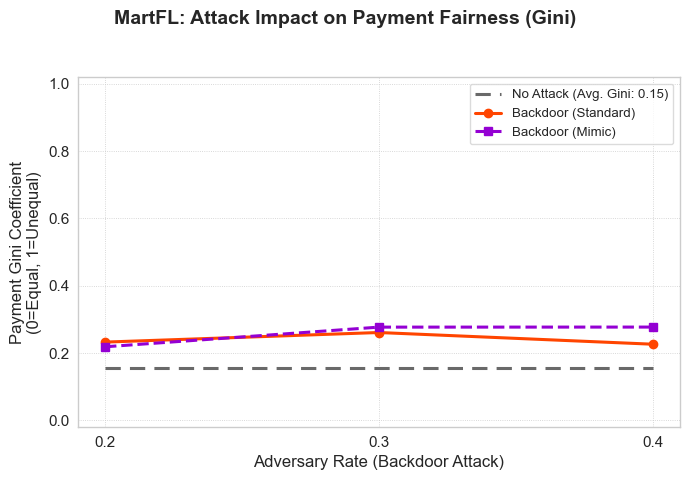

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED ---
# summary_df_avg = preprocess_experiment_data(...)

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    if 'PAYMENT_GINI_COEFFICIENT' in plot_data.columns:
        plot_data['PAYMENT_GINI_COEFFICIENT'] = pd.to_numeric(plot_data['PAYMENT_GINI_COEFFICIENT'], errors='coerce')
        plot_data.dropna(subset=['PAYMENT_GINI_COEFFICIENT'], inplace=True)
    else:
        print("PAYMENT_GINI_COEFFICIENT column not found.")
        # return or exit

    # 1. "No Attack" Gini Baseline (Averaged over ALL other variations including IS_SYBIL)
    no_attack_gini_data = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_gini_data.empty:
        no_attack_overall_avg_gini = no_attack_gini_data['PAYMENT_GINI_COEFFICIENT'].mean()
    else:
        no_attack_overall_avg_gini = np.nan

    # 2. "Backdoor Attack" Gini Data, grouped by IS_SYBIL for each ADV_RATE
    adv_rates_to_plot_on_x_for_attack = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
    ].copy()

    if not backdoor_attack_filtered.empty:
        # Group by ADV_RATE and IS_SYBIL, then take the mean (in case of multiple runs per combo)
        # This effectively gives us one line per IS_SYBIL state for the backdoor attack
        backdoor_gini_by_sybil_adv_rate = backdoor_attack_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )['PAYMENT_GINI_COEFFICIENT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        
        adv_rates_with_backdoor_gini_data = sorted(backdoor_gini_by_sybil_adv_rate['ADV_RATE'].unique())
    else:
        backdoor_gini_by_sybil_adv_rate = pd.DataFrame(columns=['ADV_RATE', 'IS_SYBIL', 'PAYMENT_GINI_COEFFICIENT'])
        adv_rates_with_backdoor_gini_data = []
        print(f"Warning: No 'Backdoor' Gini data for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")

    # --- Plotting ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 9.5 # Adjusted for 3 items
    LINE_WIDTH = 2.2
    MARKER_SIZE = 6

    fig, ax = plt.subplots(figsize=(7, 4.8)) # Slightly taller for legend if needed

    # Define colors and styles
    no_attack_color = 'dimgray'
    backdoor_sybil_false_color = 'orangered' # Standard Backdoor
    backdoor_sybil_mimic_color = 'darkviolet'  # Mimic Backdoor

    backdoor_sybil_false_style = '-'
    backdoor_sybil_mimic_style = '--'

    backdoor_sybil_false_marker = 'o'
    backdoor_sybil_mimic_marker = 's'

    legend_elements = []

    # Determine x-range for horizontal "No Attack" line
    xmin_hline = min(adv_rates_with_backdoor_gini_data) if adv_rates_with_backdoor_gini_data else 0.1
    xmax_hline = max(adv_rates_with_backdoor_gini_data) if adv_rates_with_backdoor_gini_data else 0.4

    # 1. Plot "No Attack" Gini as a single HORIZONTAL BASELINE LINE
    if pd.notna(no_attack_overall_avg_gini):
        ax.hlines(y=no_attack_overall_avg_gini, xmin=xmin_hline, xmax=xmax_hline,
                  color=no_attack_color,
                  linestyle=(0, (5,3)), # Loosely dotted
                  linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=no_attack_color, linestyle=(0,(5,3)), lw=LINE_WIDTH,
                                      label=f'No Attack (Avg. Gini: {no_attack_overall_avg_gini:.2f})'))

    # 2. Plot "Backdoor Attack" Gini, splitting lines by IS_SYBIL
    if not backdoor_gini_by_sybil_adv_rate.empty:
        # Plot for IS_SYBIL = 'False' (Standard Backdoor)
        data_sybil_false = backdoor_gini_by_sybil_adv_rate[backdoor_gini_by_sybil_adv_rate['IS_SYBIL'] == 'False']
        if not data_sybil_false.empty:
            ax.plot(data_sybil_false['ADV_RATE'], data_sybil_false['PAYMENT_GINI_COEFFICIENT'],
                    color=backdoor_sybil_false_color,
                    linestyle=backdoor_sybil_false_style,
                    marker=backdoor_sybil_false_marker,
                    linewidth=LINE_WIDTH,
                    markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=backdoor_sybil_false_color,
                                          linestyle=backdoor_sybil_false_style, marker=backdoor_sybil_false_marker,
                                          markerfacecolor=backdoor_sybil_false_color, markersize=MARKER_SIZE,
                                          lw=LINE_WIDTH, label='Backdoor (Standard)'))

        # Plot for IS_SYBIL = 'mimic'
        data_sybil_mimic = backdoor_gini_by_sybil_adv_rate[backdoor_gini_by_sybil_adv_rate['IS_SYBIL'] == 'mimic']
        if not data_sybil_mimic.empty:
            ax.plot(data_sybil_mimic['ADV_RATE'], data_sybil_mimic['PAYMENT_GINI_COEFFICIENT'],
                    color=backdoor_sybil_mimic_color,
                    linestyle=backdoor_sybil_mimic_style,
                    marker=backdoor_sybil_mimic_marker,
                    linewidth=LINE_WIDTH,
                    markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=backdoor_sybil_mimic_color,
                                          linestyle=backdoor_sybil_mimic_style, marker=backdoor_sybil_mimic_marker,
                                          markerfacecolor=backdoor_sybil_mimic_color, markersize=MARKER_SIZE,
                                          lw=LINE_WIDTH, label='Backdoor (Mimic)'))


    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Payment Gini Coefficient\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
    ax.set_ylim(-0.02, 1.02)

    # X-axis Ticks
    if adv_rates_with_backdoor_gini_data:
        ax.set_xticks(ticks=adv_rates_with_backdoor_gini_data)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_gini_data])
    else:
        ax.set_xticks(ticks=adv_rates_to_plot_on_x_for_attack)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x_for_attack])

    ax.grid(True, which='major', linestyle=':', linewidth=0.6)

    # Legend: 3 items, can be single column or adjusted
    if legend_elements:
        ax.legend(handles=legend_elements,
                  fontsize=LEGEND_FONT_SIZE,
                  loc='best',
                  frameon=True, edgecolor='lightgray')

    fig.suptitle(f'{current_aggregation_method}: Attack Impact on Payment Fairness (Gini)',
                 fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_gini_sybil_contrast.pdf", bbox_inches='tight')
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

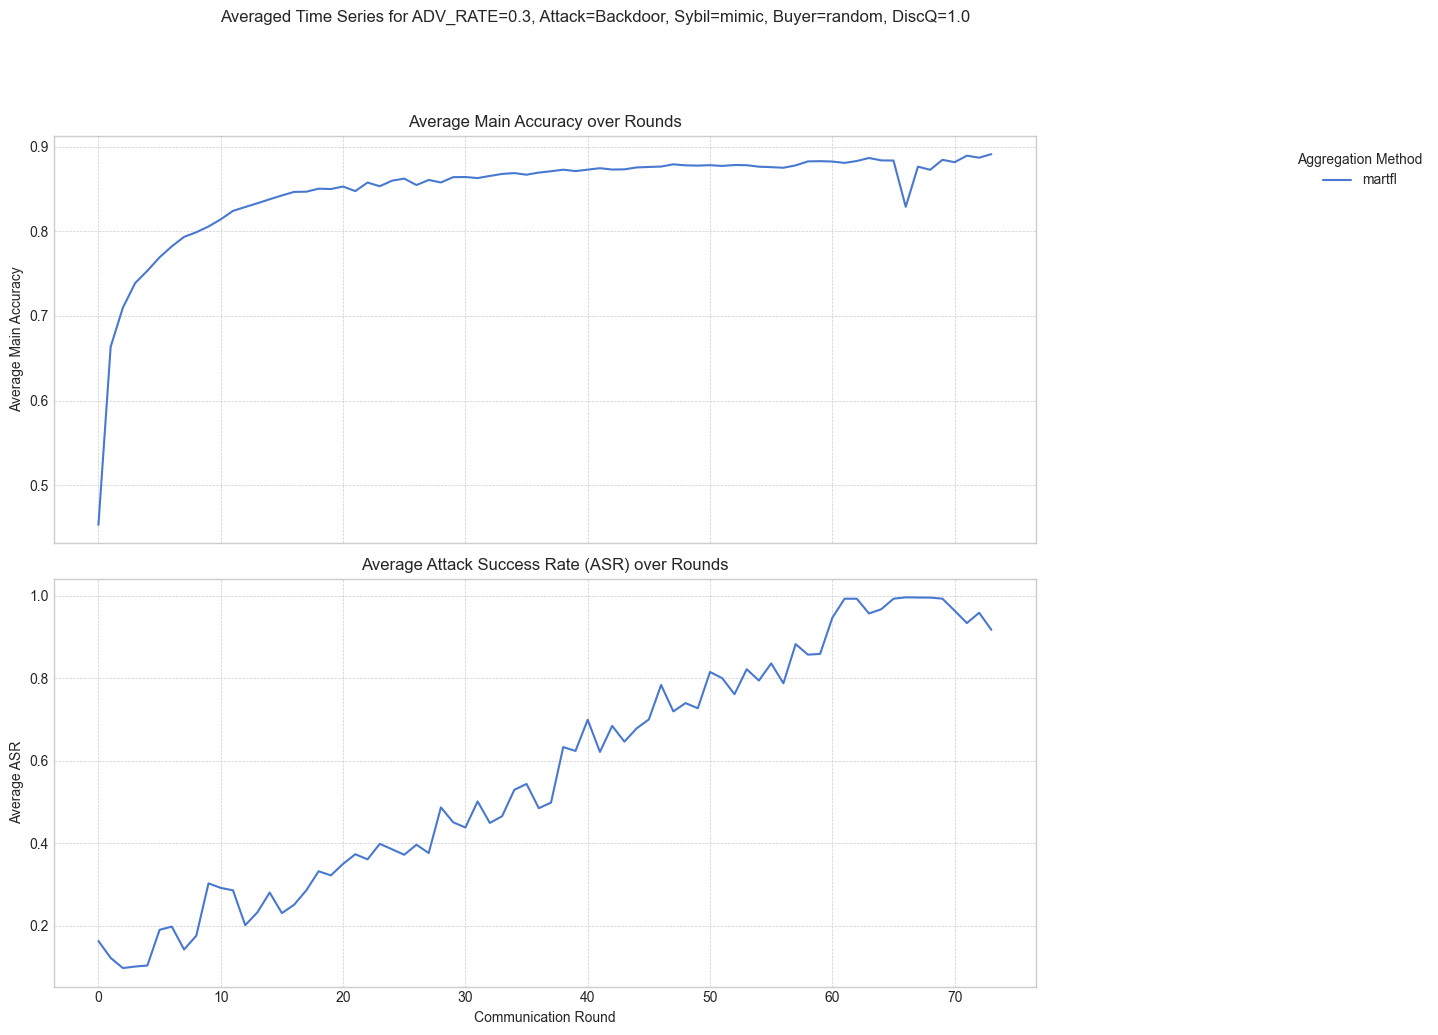

In [47]:
# Cell 8: Plot 6 - Time Series: AVERAGE Accuracy and ASR over Rounds (from all_rounds.csv)

if not all_rounds_df.empty:
    # --- Select a FEW specific experiment configurations to plot time series ---
    # Define the parameters that constitute a unique experiment configuration for averaging
    CONFIG_ADV_RATE = 0.3
    CONFIG_ATTACK_METHOD = 'Backdoor'
    CONFIG_IS_SYBIL = 'mimic'
    CONFIG_BUYER_MODE = 'random'
    CONFIG_DISCOVERY_QUALITY = 1.0    
    # CONFIG_DATASET = 'FMNIST' # Add if you have this column and want to filter by it

    # Filter for the base configuration
    base_time_series_df = all_rounds_df[
        (all_rounds_df['ADV_RATE'] == CONFIG_ADV_RATE) &
        (all_rounds_df['ATTACK_METHOD'] == CONFIG_ATTACK_METHOD) &
        (all_rounds_df['IS_SYBIL'] == CONFIG_IS_SYBIL) &
        (all_rounds_df['buyer_data_mode'] == CONFIG_BUYER_MODE) &
        (all_rounds_df['discovery_quality'] == CONFIG_DISCOVERY_QUALITY)
        # Add (all_rounds_df['dataset_name'] == CONFIG_DATASET) if needed
    ].copy()

    if not base_time_series_df.empty:
        # Group by the varying parameter (e.g., AGGREGATION_METHOD) and 'round', then average
        # Add other identifying columns to groupby if they also define a unique setup for comparison
        # For example, if 'AGGREGATION_METHOD' and 'TRIGGER_MODE' vary for this specific plot.
        # Here, we assume we are comparing different 'AGGREGATION_METHOD's.
        grouping_cols = ['AGGREGATION_METHOD', 'round']
        
        # If you have other parameters that vary within this slice, add them to grouping_cols
        # e.g., if 'CHANGE_BASE' also varies for MartFL under these conditions:
        # if 'CHANGE_BASE' in base_time_series_df.columns:
        #    grouping_cols.insert(1, 'CHANGE_BASE') # Insert before 'round'

        averaged_time_series_df = base_time_series_df.groupby(grouping_cols, as_index=False)[
            ['main_acc', 'asr', 'cost_per_round'] # Add other metrics you want averaged over time
        ].mean() # Use .median() if outliers are a concern

        if not averaged_time_series_df.empty:
            fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True) # Make it 3,1 if plotting cost_per_round

            # Plot Main Accuracy over rounds
            sns.lineplot(data=averaged_time_series_df, x='round', y='main_acc', hue='AGGREGATION_METHOD', ax=axes[0], legend='full', errorbar=('ci', 95))
            axes[0].set_title(f'Average Main Accuracy over Rounds')
            axes[0].set_ylabel('Average Main Accuracy')
            axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

            # Plot ASR over rounds (only if an attack is present)
            if CONFIG_ATTACK_METHOD != 'None':
                sns.lineplot(data=averaged_time_series_df, x='round', y='asr', hue='AGGREGATION_METHOD', ax=axes[1], legend=False, errorbar=('ci', 95))
                axes[1].set_title(f'Average Attack Success Rate (ASR) over Rounds')
                axes[1].set_ylabel('Average ASR')
            else:
                axes[1].set_title('ASR (No Attack Scenario)')
                axes[1].text(0.5, 0.5, 'No Attack', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
            
            axes[1].set_xlabel('Communication Round')
            axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

            # Optional: Plot Average Cost per Round
            # sns.lineplot(data=averaged_time_series_df, x='round', y='cost_per_round', hue='AGGREGATION_METHOD', ax=axes[2], legend=False)
            # axes[2].set_title(f'Average Cost Per Round')
            # axes[2].set_ylabel('Average Cost')
            # axes[2].set_xlabel('Communication Round')
            # axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # Consolidate legends
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, title='Aggregation Method', loc='upper right', bbox_to_anchor=(1.2, 0.9)) # Adjusted bbox
            axes[0].get_legend().remove()

            plt.suptitle(f'Averaged Time Series for ADV_RATE={CONFIG_ADV_RATE}, Attack={CONFIG_ATTACK_METHOD}, Sybil={CONFIG_IS_SYBIL}, Buyer={CONFIG_BUYER_MODE}, DiscQ={CONFIG_DISCOVERY_QUALITY}', y=1.03)
            plt.tight_layout(rect=[0, 0, 0.88, 0.97]) # Adjust rect for legend
            plt.show()
        else:
            print("Averaged time series data is empty after grouping. Check grouping columns and filters.")
    else:
        print(f"No data found for the specific time series scenario in Plot 6 (ADV_RATE={CONFIG_ADV_RATE}, etc.). Adjust filters.")
else:
    print("all_rounds_df is empty. Skipping Plot 6.")

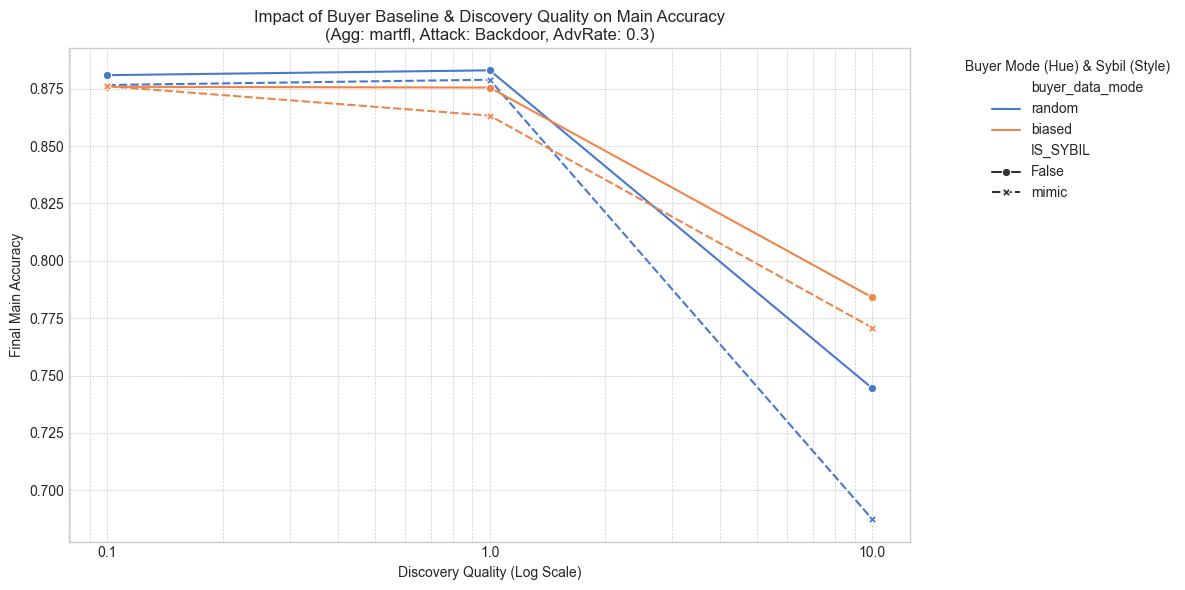

In [49]:
if not summary_df_avg.empty:
    # --- Select a specific aggregation and attack scenario ---
    AGG_METHOD_TO_ANALYZE = 'martfl' # or 'fltrust', 'fedavg'
    ATTACK_TO_ANALYZE = 'Backdoor' # or 'None'
    ADV_RATE_TO_ANALYZE = 0.3

    focus_df = summary_df_avg[
        (summary_df_avg['AGGREGATION_METHOD'] == AGG_METHOD_TO_ANALYZE) &
        (summary_df_avg['ATTACK_METHOD'] == ATTACK_TO_ANALYZE) &
        (summary_df_avg['ADV_RATE'] == ADV_RATE_TO_ANALYZE)
    ].copy()

    if not focus_df.empty:
        # Ensure discovery_quality is numeric for proper sorting/plotting if it's read as string
        focus_df['discovery_quality'] = pd.to_numeric(focus_df['discovery_quality'], errors='coerce')
        focus_df.dropna(subset=['discovery_quality'], inplace=True)


        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=focus_df,
            x='discovery_quality',
            y='FINAL_MAIN_ACC',
            hue='buyer_data_mode', # How buyer's baseline affects things
            style='IS_SYBIL',      # How sybil/mimic interacts
            markers=True,
            errorbar=('ci', 95) if 'FINAL_MAIN_ACC_STD' in focus_df.columns else None
        )
        plt.xscale('log') # Discovery quality might be on a log scale (0.1, 1.0, 10.0)
        plt.title(f'Impact of Buyer Baseline & Discovery Quality on Main Accuracy\n(Agg: {AGG_METHOD_TO_ANALYZE}, Attack: {ATTACK_TO_ANALYZE}, AdvRate: {ADV_RATE_TO_ANALYZE})')
        plt.xlabel('Discovery Quality (Log Scale)')
        plt.ylabel('Final Main Accuracy')
        plt.xticks(focus_df['discovery_quality'].unique(), labels=focus_df['discovery_quality'].unique()) # Show actual values
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Buyer Mode (Hue) & Sybil (Style)', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for the specific scenario in Plot 7 (Agg: {AGG_METHOD_TO_ANALYZE}, etc.). Adjust filters.")
else:
    print("summary_df_avg is empty. Skipping Plot 7.")

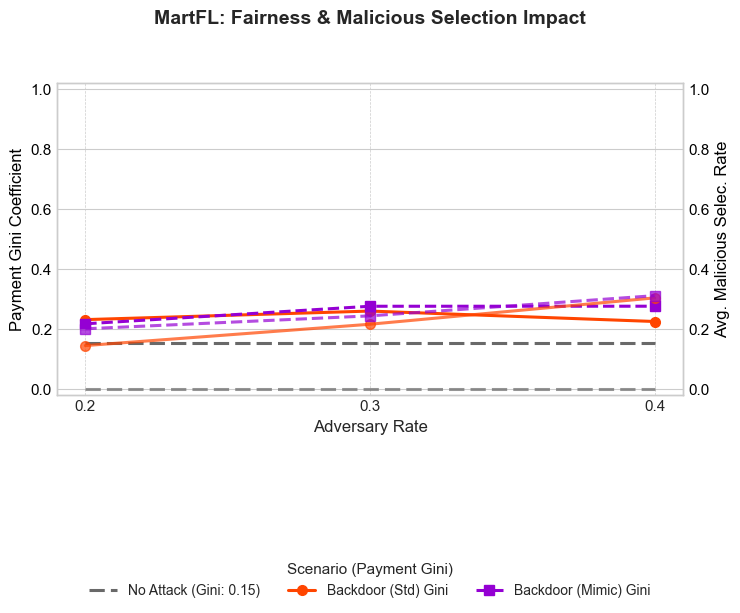

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED from a PREVIOUS cell ---
# Example: summary_df_avg = preprocess_experiment_data(...)

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation specific to this plot ---
    plot_data_focus = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    # 1. "No Attack" Baseline (Overall Average)
    no_attack_data = plot_data_focus[plot_data_focus['ATTACK_METHOD'] == 'No Attack'].copy()
    no_attack_avg_gini = no_attack_data['PAYMENT_GINI_COEFFICIENT'].mean() if not no_attack_data.empty else np.nan
    no_attack_avg_mal_select_rate = 0.0 # By definition for no attack

    # 2. "Backdoor Attack" Data, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_data = plot_data_focus[
        (plot_data_focus['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_focus['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    # Prepare grouped data for backdoor attack lines
    if not backdoor_attack_data.empty:
        # We need Gini and Malicious Selection Rate for each IS_SYBIL type at each ADV_RATE
        backdoor_perf_by_sybil = backdoor_attack_data.groupby(['ADV_RATE', 'IS_SYBIL'], as_index=False).agg(
            AVG_GINI=('PAYMENT_GINI_COEFFICIENT', 'mean'),
            AVG_MAL_SELECT_RATE=('AVG_ADVERSARY_SELECTION_RATE', 'mean')
        ).sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_backdoor_data = sorted(backdoor_perf_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning: No 'Backdoor' data for Gini/Selection plot for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_perf_by_sybil = pd.DataFrame()
        adv_rates_present_in_backdoor_data = []

    # --- Plotting ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11
    LINE_WIDTH = 2.2; MARKER_SIZE = 7

    fig, ax1 = plt.subplots(figsize=(7.5, 5.0)) # ax1 for Gini Coefficient

    # Define visual properties for the 3 main conditions
    colors = {
        'No Attack': 'dimgray',
        'Backdoor (Standard)': 'orangered', # IS_SYBIL = False
        'Backdoor (Mimic)': 'darkviolet'    # IS_SYBIL = mimic
    }
    linestyles = {
        'No Attack': (0, (5, 2)),       # Loosely dotted baseline
        'Backdoor (Standard)': '-',     # Solid
        'Backdoor (Mimic)': '--'        # Dashed
    }
    markers = { # Only for backdoor lines, baseline is hline
        'Backdoor (Standard)': 'o',
        'Backdoor (Mimic)': 's'
    }
    legend_elements = []
    xmin_hline = min(adv_rates_present_in_backdoor_data) if adv_rates_present_in_backdoor_data else 0.1
    xmax_hline = max(adv_rates_present_in_backdoor_data) if adv_rates_present_in_backdoor_data else 0.4

    # --- Plot Gini Coefficient (ax1) ---
    # 1a. "No Attack" Gini Baseline (one line)
    if pd.notna(no_attack_avg_gini):
        ax1.hlines(y=no_attack_avg_gini, xmin=xmin_hline, xmax=xmax_hline,
                   color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Gini: {no_attack_avg_gini:.2f})'))

    # 1b. "Backdoor Attack" Gini (two lines: Standard and Mimic)
    if not backdoor_perf_by_sybil.empty:
        # Standard Backdoor (IS_SYBIL == 'False')
        data_std_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'False']
        if not data_std_backdoor.empty:
            ax1.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor['AVG_GINI'],
                     color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                     marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor Gini (Std)'))
        # Mimic Backdoor (IS_SYBIL == 'mimic')
        data_mimic_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic_backdoor.empty:
            ax1.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor['AVG_GINI'],
                     color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                     marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor Gini (Mimic)'))

    ax1.set_xlabel('Adversary Rate', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.set_ylabel('Payment Gini Coefficient', color='black', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=TICK_LABEL_FONT_SIZE)
    ax1.set_ylim(-0.02, 1.02)
    ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='y')

    # --- Plot Malicious Selection Rate (ax2) ---
    ax2 = ax1.twinx()

    # 2a. "No Attack" Malicious Selection Rate Baseline (one line at y=0)
    ax2.hlines(y=no_attack_avg_mal_select_rate, xmin=xmin_hline, xmax=xmax_hline,
               color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH, alpha=0.7) # Same style as Gini baseline
    # No separate legend entry for this if it's always 0, implied by "No Attack" context

    # 2b. "Backdoor Attack" Malicious Selection Rate (two lines: Standard and Mimic)
    if not backdoor_perf_by_sybil.empty and 'AVG_MAL_SELECT_RATE' in backdoor_perf_by_sybil.columns:
        data_std_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'False']
        if not data_std_backdoor.empty:
            ax2.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor['AVG_MAL_SELECT_RATE'],
                     color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                     marker=markers['Backdoor (Standard)'],# Use same marker as Gini for this condition
                     linewidth=LINE_WIDTH, markersize=MARKER_SIZE, alpha=0.7) # Slightly transparent
            # We use a combined legend, so no individual labels here unless customizing further

        data_mimic_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic_backdoor.empty:
            ax2.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor['AVG_MAL_SELECT_RATE'],
                     color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                     marker=markers['Backdoor (Mimic)'], # Use same marker as Gini
                     linewidth=LINE_WIDTH, markersize=MARKER_SIZE, alpha=0.7) # Slightly transparent

    ax2.set_ylabel('Avg. Malicious Selec. Rate', color='black', fontsize=AXIS_LABEL_FONT_SIZE)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=TICK_LABEL_FONT_SIZE)
    ax2.set_ylim(-0.02, 1.02)

    # --- Final Touches ---
    if adv_rates_present_in_backdoor_data:
        ax1.set_xticks(ticks=adv_rates_present_in_backdoor_data)
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_backdoor_data], fontsize=TICK_LABEL_FONT_SIZE)
    else:
        ax1.set_xticks(ticks=adv_rates_to_plot_on_x) # Fallback
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x], fontsize=TICK_LABEL_FONT_SIZE)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')

    # Combined Legend (Manually create handles for clarity if seaborn's auto-legend is messy)
    # Using the legend_elements list built earlier
    # For this simplified plot, we want to clearly distinguish the 3 main scenarios for Gini
    # and imply the selection rate lines follow the same color/style for backdoor.

    # Rebuild legend_elements for just the 3 main Gini lines shown on ax1
    # The selection rate lines on ax2 will share colors/styles with Gini lines for backdoor
    final_legend_elements = []
    if pd.notna(no_attack_avg_gini):
        final_legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Gini: {no_attack_avg_gini:.2f})'))
    if not backdoor_perf_by_sybil.empty:
        if not data_std_backdoor.empty:
            final_legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Std) Gini')) # Label indicates it's Gini
        if not data_mimic_backdoor.empty:
            final_legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Mimic) Gini'))

    # Add a note about the secondary axis lines if desired, or assume context from y-labels
    # For simplicity, we let the y-axis labels distinguish the metrics.

    if final_legend_elements:
        fig.legend(handles=final_legend_elements,
                   title='Scenario (Payment Gini)',
                   title_fontsize=LEGEND_TITLE_FONT_SIZE,
                   fontsize=LEGEND_FONT_SIZE,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.20), # Adjust y for spacing
                   ncol=3, # 3 items
                   frameon=False)

    fig.suptitle(f'{current_aggregation_method}: Fairness & Malicious Selection Impact',
                 fontsize=TITLE_FONT_SIZE, y=1.0, fontweight='bold')
    plt.tight_layout(rect=[0, 0.12, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_simplified_gini_selection.pdf", bbox_inches='tight')
    plt.show()
else:
    print("summary_df_avg is empty. Cannot generate plot.")

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED ---
# And contains 'BENIGN_PAYMENT_GINI_COEFFICIENT'
# summary_df_avg = preprocess_experiment_data(...)

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data_benign_gini = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    if 'BENIGN_PAYMENT_GINI_COEFFICIENT' not in plot_data_benign_gini.columns:
        print("Error: 'BENIGN_PAYMENT_GINI_COEFFICIENT' column not found. Cannot create this plot.")
        # return or exit
    else:
        plot_data_benign_gini['BENIGN_PAYMENT_GINI_COEFFICIENT'] = pd.to_numeric(
            plot_data_benign_gini['BENIGN_PAYMENT_GINI_COEFFICIENT'], errors='coerce'
        )
        plot_data_benign_gini.dropna(subset=['BENIGN_PAYMENT_GINI_COEFFICIENT'], inplace=True)

    # 1. "No Attack" Benign Gini Baseline (Averaged over IS_SYBIL)
    no_attack_data = plot_data_benign_gini[plot_data_benign_gini['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_data.empty:
        no_attack_avg_benign_gini = no_attack_data['BENIGN_PAYMENT_GINI_COEFFICIENT'].mean()
    else:
        no_attack_avg_benign_gini = np.nan

    # 2. "Backdoor Attack" Benign Gini Data, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_benign_gini_data = plot_data_benign_gini[
        (plot_data_benign_gini['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_benign_gini['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    if not backdoor_benign_gini_data.empty:
        backdoor_benign_gini_by_sybil = backdoor_benign_gini_data.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )['BENIGN_PAYMENT_GINI_COEFFICIENT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_data = sorted(backdoor_benign_gini_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning: No 'Backdoor' data for Benign Gini for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_benign_gini_by_sybil = pd.DataFrame()
        adv_rates_present_in_data = []

    # --- Plotting Benign Gini ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7

    fig, ax = plt.subplots(figsize=(7, 4.8))

    colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'orangered', 'Backdoor (Mimic)': 'darkviolet' }
    linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
    markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
    legend_elements = []

    xmin_hline = min(adv_rates_present_in_data) if adv_rates_present_in_data else 0.1
    xmax_hline = max(adv_rates_present_in_data) if adv_rates_present_in_data else 0.4

    # Plot "No Attack" Benign Gini Baseline
    if pd.notna(no_attack_avg_benign_gini):
        ax.hlines(y=no_attack_avg_benign_gini, xmin=xmin_hline, xmax=xmax_hline,
                  color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Avg. Benign Gini: {no_attack_avg_benign_gini:.2f})'))

    # Plot "Backdoor Attack" Benign Gini (Standard and Mimic)
    if not backdoor_benign_gini_by_sybil.empty:
        data_std = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'False']
        if not data_std.empty:
            ax.plot(data_std['ADV_RATE'], data_std['BENIGN_PAYMENT_GINI_COEFFICIENT'],
                    color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                    marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Std) Benign Gini'))

        data_mimic = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic.empty:
            ax.plot(data_mimic['ADV_RATE'], data_mimic['BENIGN_PAYMENT_GINI_COEFFICIENT'],
                    color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                    marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Mimic) Benign Gini'))

    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Benign Seller Payment Gini\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
    ax.set_ylim(-0.02, 1.02)
    if adv_rates_present_in_data:
        ax.set_xticks(ticks=adv_rates_present_in_data); ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_data])
    ax.grid(True, which='major', linestyle=':', linewidth=0.6)

    if legend_elements:
        ax.legend(handles=legend_elements, fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
    fig.suptitle(f'{current_aggregation_method}: Fairness Among Benign Sellers (Gini)',
                 fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_benign_gini.pdf", bbox_inches='tight')
    plt.show()
else:
    print("summary_df_avg is empty. Cannot generate Benign Gini plot.")

Error: 'BENIGN_PAYMENT_GINI_COEFFICIENT' column not found. Cannot create this plot.


KeyError: 'BENIGN_PAYMENT_GINI_COEFFICIENT'

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED from a PREVIOUS cell ---
# And contains 'AVG_BENIGN_SELLER_SELECTION_RATE' and 'AVG_ADVERSARY_SELECTION_RATE'

# Example: For standalone testing
# if 'summary_df_avg' not in locals() or summary_df_avg.empty:
#     print("INFO: 'summary_df_avg' not found or empty. Creating a dummy DataFrame for Selection Rate plot demonstration.")
#     data_dummy_select = {
#         'AGGREGATION_METHOD': ['MartFL']*12,
#         'ATTACK_METHOD': ['No Attack']*4 + ['Backdoor']*8,
#         'IS_SYBIL': ['False', 'mimic']*2 + ['False', 'mimic']*4,
#         'ADV_RATE': [0.0]*4 + [0.1,0.1,0.2,0.2,0.3,0.3,0.4,0.4],
#         'AVG_BENIGN_SELLER_SELECTION_RATE': np.concatenate([np.random.uniform(0.8,0.95,4), np.random.uniform(0.3,0.8,8)]),
#         'AVG_ADVERSARY_SELECTION_RATE': np.concatenate([np.zeros(4), np.random.uniform(0.1,0.7,8)])
#     }
#     summary_df_avg = pd.DataFrame(data_dummy_select)
#     # Minimal preprocessing for dummy
#     summary_df_avg.loc[summary_df_avg['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0
#     for col in ['AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE']:
#         summary_df_avg[col] = pd.to_numeric(summary_df_avg[col], errors='coerce')


if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation for Selection Rate Plot ---
    plot_data_select = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    required_cols = ['AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE']
    missing_cols = [col for col in required_cols if col not in plot_data_select.columns]
    if missing_cols:
        print(f"Error: Following columns not found: {', '.join(missing_cols)}. Cannot create selection rate plot.")
        # Exit this cell's logic
        plot_data_select = pd.DataFrame()
    else:
        for col in required_cols:
            plot_data_select[col] = pd.to_numeric(plot_data_select[col], errors='coerce')
        rows_before_dropna_sel = len(plot_data_select)
        plot_data_select.dropna(subset=required_cols, inplace=True)
        if len(plot_data_select) < rows_before_dropna_sel:
            print(f"Warning (Selection Rates): Dropped {rows_before_dropna_sel - len(plot_data_select)} rows due to NaN values in selection rate columns.")


    # 1. "No Attack" Selection Rates
    no_attack_select_data = plot_data_select[plot_data_select['ATTACK_METHOD'] == 'No Attack'].copy()
    no_attack_avg_benign_select_by_sybil = {}
    if not no_attack_select_data.empty:
        baselines = no_attack_select_data.groupby('IS_SYBIL')['AVG_BENIGN_SELLER_SELECTION_RATE'].mean()
        no_attack_avg_benign_select_by_sybil = baselines.to_dict()
    no_attack_avg_mal_select = 0.0


    # 2. "Backdoor Attack" Selection Rates, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_select_data_filtered = plot_data_select[
        (plot_data_select['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_select['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    if not backdoor_select_data_filtered.empty:
        backdoor_select_by_sybil = backdoor_select_data_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )[required_cols].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_data_sel = sorted(backdoor_select_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning (Selection Rates): No 'Backdoor' data for Selection Rates for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_select_by_sybil = pd.DataFrame()
        adv_rates_present_in_data_sel = []

    # --- Plotting Selection Rates ---
    if not plot_data_select.empty and not missing_cols: # Check if essential columns were present
        TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
        LEGEND_FONT_SIZE = 9; LEGEND_TITLE_FONT_SIZE = 10
        LINE_WIDTH = 2.2; MARKER_SIZE = 7

        fig, ax = plt.subplots(figsize=(7.5, 5.2))

        colors_benign = {'False': 'mediumseagreen', 'mimic': 'deepskyblue'}
        colors_malicious = {'False': 'salmon', 'mimic': 'mediumorchid'}
        linestyles = {'False': '-', 'mimic': '--'} # Shared for benign/malicious pairs under same sybil
        markers_benign = {'False': 'o', 'mimic': 's'}
        markers_malicious = {'False': '^', 'mimic': 'X'}
        legend_elements_sel = []

        xmin_hline_sel = min(adv_rates_present_in_data_sel) if adv_rates_present_in_data_sel else 0.1
        xmax_hline_sel = max(adv_rates_present_in_data_sel) if adv_rates_present_in_data_sel else 0.4

        # Plot "No Attack" Benign Seller Selection Rate Baselines
        for sybil_state, avg_benign_rate in no_attack_avg_benign_select_by_sybil.items():
            if pd.notna(avg_benign_rate):
                ax.hlines(y=avg_benign_rate, xmin=xmin_hline_sel, xmax=xmax_hline_sel,
                          color=colors_benign.get(sybil_state, 'grey'),
                          linestyle=(0,(5,3)), linewidth=LINE_WIDTH)
                legend_elements_sel.append(Line2D([0],[0], color=colors_benign.get(sybil_state, 'grey'), linestyle=(0,(5,3)),
                                                lw=LINE_WIDTH, label=f'No Atk. Benign (Syb:{sybil_state[0]}) ({avg_benign_rate:.2f})'))
        # Plot "No Attack" Malicious Seller Selection Rate Baseline (at y=0)
        ax.hlines(y=no_attack_avg_mal_select, xmin=xmin_hline_sel, xmax=xmax_hline_sel,
                  color='lightgrey', linestyle=(0,(1,2)), linewidth=LINE_WIDTH)
        legend_elements_sel.append(Line2D([0],[0], color='lightgrey', linestyle=(0,(1,2)), lw=LINE_WIDTH, label='No Atk. Malicious (0.00)'))

        # Plot "Backdoor Attack" Selection Rates
        if not backdoor_select_by_sybil.empty:
            for sybil_state, group_df in backdoor_select_by_sybil.groupby('IS_SYBIL'):
                # Benign Selection Rate under attack
                ax.plot(group_df['ADV_RATE'], group_df['AVG_BENIGN_SELLER_SELECTION_RATE'],
                        color=colors_benign.get(sybil_state, 'blue'),
                        linestyle=linestyles.get(sybil_state, '-'),
                        marker=markers_benign.get(sybil_state, 'o'),
                        linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                legend_elements_sel.append(Line2D([0],[0], color=colors_benign.get(sybil_state, 'blue'), linestyle=linestyles.get(sybil_state, '-'),
                                                  marker=markers_benign.get(sybil_state, 'o'), markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label=f'Benign Sel. (Syb:{sybil_state[0]})'))
                # Malicious Selection Rate under attack
                ax.plot(group_df['ADV_RATE'], group_df['AVG_ADVERSARY_SELECTION_RATE'],
                        color=colors_malicious.get(sybil_state, 'red'),
                        linestyle=linestyles.get(sybil_state, '-'),
                        marker=markers_malicious.get(sybil_state, '^'),
                        linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                legend_elements_sel.append(Line2D([0],[0], color=colors_malicious.get(sybil_state, 'red'), linestyle=linestyles.get(sybil_state, '-'),
                                                  marker=markers_malicious.get(sybil_state, '^'), markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label=f'Malicious Sel. (Syb:{sybil_state[0]})'))

        ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
        ax.set_ylabel('Average Seller Selection Rate', fontsize=AXIS_LABEL_FONT_SIZE)
        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
        ax.set_ylim(-0.05, 1.05)
        if adv_rates_present_in_data_sel:
            ax.set_xticks(ticks=adv_rates_present_in_data_sel)
            ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_data_sel])
        ax.grid(True, which='major', linestyle=':', linewidth=0.6)

        if legend_elements_sel:
            legend_elements_sel.sort(key=lambda x: (
                "No Atk" not in x.get_label(),
                "Benign" not in x.get_label(),
                "Syb:F" not in x.get_label().split('(')[-1]
            ))
            fig.legend(handles=legend_elements_sel, title='Seller Type & Condition',
                       title_fontsize=LEGEND_TITLE_FONT_SIZE, fontsize=LEGEND_FONT_SIZE,
                       loc='lower center', bbox_to_anchor=(0.5, -0.30),
                       ncol=3, frameon=False) # ncol=3 for 6 main lines

        fig.suptitle(f'{current_aggregation_method}: Seller Selection Dynamics Under Attack',
                     fontsize=TITLE_FONT_SIZE, y=1.0, fontweight='bold')
        plt.tight_layout(rect=[0, 0.18, 1, 0.95])
        plt.show()
    else:
        print("Not enough data or required columns missing for Selection Rate plot.")

else:
    print("DataFrame 'summary_df_avg' is not loaded or is empty.")

Error: Following columns not found: AVG_BENIGN_SELLER_SELECTION_RATE. Cannot create selection rate plot.


KeyError: 'ATTACK_METHOD'

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique = processed_df[col].unique()
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else:
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. Original unique: {original_unique}, New unique: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns:
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                # Convert to numeric first, coercing errors
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()

                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric.")

                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' for float processing not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique():
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD, skipping ADV_RATE=0 assignment.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1, 'discovery_quality': 1, 'FINAL_MAIN_ACC': 4, 'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3, 'BENIGN_PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_ADVERSARY_SELECTION_RATE': 3, 'AVG_BENIGN_SELLER_SELECTION_RATE': 3,
    'COST_OF_CONVERGENCE': 0, 'TOTAL_COST': 0
}
CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {'single': 'Backdoor', np.nan: 'No Attack', 'None': 'No Attack'},
    # 'IS_SYBIL': {'True': 'Mimic', 'False': 'Standard'} # If needed
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame()
try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(summary_df_avg_raw, FLOAT_PRECISIONS, CATEGORICAL_MAPPINGS)
    if not summary_df_avg.empty: display(summary_df_avg.head())
except FileNotFoundError: print(f"Error: summary_avg.csv not found in {OUTPUT_DIR}.")
except Exception as e: print(f"Error during summary_df_avg loading/preprocessing: {e}")

plt.style.use('seaborn-v0_8-whitegrid'); sns.set_palette("muted")

if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification ---")
    # ... (verification print statements from previous full cell code) ...
else:
    print("\nsummary_df_avg is empty after attempting to load and process.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' mapped. Original unique: ['single' nan], New unique: ['Backdoor' 'No Attack']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 0
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Column 'PAYMENT_GINI_COEFFICIENT' rounded. NaNs after rounding: 0
Processing float column: AVG_ADVERSARY_SELECTION_RATE with precision 3
  Column 'AVG_ADVERSARY_SELECTION_RATE' rounded. NaNs after rounding: 0
Processing float column: AVG_BENIGN_SELLER_SELECTION_RATE with precision 3
  Column 'AVG_BENIGN_SELLER_SELECTION_RATE' rounded. NaNs after 

,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,AVG_BENIGN_SELECTION_RATE,AVG_COST_PER_ROUND,COST_OF_CONVERGENCE,TARGET_ACC_FOR_COC,COC_TARGET_REACHED_ROUND,PAYMENT_GINI_COEFFICIENT,TOTAL_COST,TOTAL_ROUNDS,AVG_BENIGN_SELLER_SELECTION_RATE,AVG_BENIGN_PAYMENT_GINI
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,0.878636,15.242015,236.0,0.8,8.666667,0.122,934.0,61.666667,0.565,0.623172
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,0.885670,15.992225,294.0,0.8,11.800000,0.143,1141.0,71.400000,0.605,0.600841
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,0.829453,14.821181,193.0,0.8,8.250000,0.146,874.0,59.000000,0.525,0.633358
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,0.840024,15.888718,233.0,0.8,10.400000,0.121,970.0,61.300000,0.578,0.603829
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,0.566184,12.153846,62.0,0.8,4.000000,0.242,316.0,26.000000,0.341,0.615042



--- Processed Summary Data Verification ---


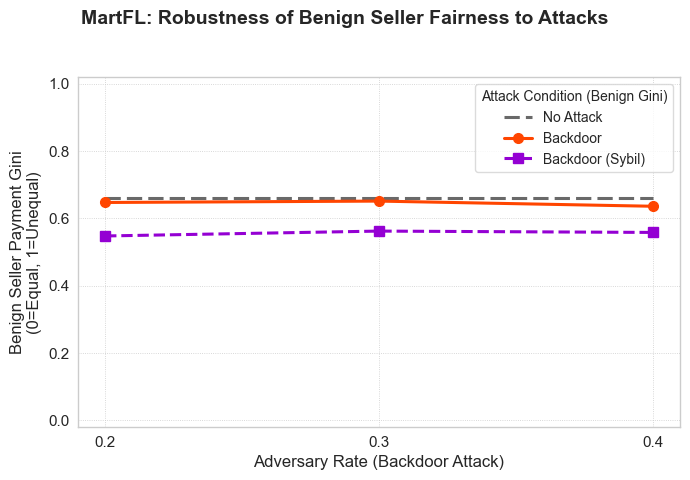

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.
# It will now use 'AVG_BENIGN_PAYMENT_GINI' from your CSV.

# Define the correct column name from your CSV
ACTUAL_BENIGN_GINI_COLUMN_NAME = 'AVG_BENIGN_PAYMENT_GINI'

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_benign_gini = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL'

    if ACTUAL_BENIGN_GINI_COLUMN_NAME not in plot_data_benign_gini.columns:
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column not found. Cannot create plot.")
    elif plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME].isna().all():
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column contains only NaN values. Cannot create plot.")
    else:
        # Column already preprocessed (numeric, rounded) by preprocess_experiment_data if listed in FLOAT_PRECISIONS
        # Ensure it's numeric if it wasn't in FLOAT_PRECISIONS, though it should be
        plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME] = pd.to_numeric(
            plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME], errors='coerce'
        )
        rows_before_dropna_bg = len(plot_data_benign_gini)
        plot_data_benign_gini.dropna(subset=[ACTUAL_BENIGN_GINI_COLUMN_NAME], inplace=True)
        if len(plot_data_benign_gini) < rows_before_dropna_bg:
            print(f"Plot Benign Gini: Dropped {rows_before_dropna_bg - len(plot_data_benign_gini)} rows with NaN {ACTUAL_BENIGN_GINI_COLUMN_NAME} values.")

        # 1. "No Attack" Benign Gini Baseline (Averaged over IS_SYBIL)
        no_attack_data_bg = plot_data_benign_gini[plot_data_benign_gini['ATTACK_METHOD'] == 'No Attack'].copy()
        no_attack_avg_benign_gini = no_attack_data_bg[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean() if not no_attack_data_bg.empty else np.nan

        # 2. "Backdoor Attack" Benign Gini Data, distinguishing IS_SYBIL
        adv_rates_to_plot_on_x = [0.2, 0.3, 0.4]
        backdoor_benign_gini_data = plot_data_benign_gini[
            (plot_data_benign_gini['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_benign_gini['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        if not backdoor_benign_gini_data.empty:
            backdoor_benign_gini_by_sybil = backdoor_benign_gini_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_in_data = sorted(backdoor_benign_gini_by_sybil['ADV_RATE'].unique())
        else:
            print(f"Warning (Benign Gini Plot): No 'Backdoor' data for Benign Gini for ADV_RATEs {adv_rates_to_plot_on_x}.")
            backdoor_benign_gini_by_sybil = pd.DataFrame()
            adv_rates_present_in_data = []

        # --- Plotting Benign Gini ---
        if not backdoor_benign_gini_by_sybil.empty or pd.notna(no_attack_avg_benign_gini):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7

            fig, ax = plt.subplots(figsize=(7, 4.8))

            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'orangered', 'Backdoor (Mimic)': 'darkviolet' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
            legend_elements_gini = []

            xmin_hline = min(adv_rates_present_in_data) if adv_rates_present_in_data else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_in_data) if adv_rates_present_in_data else max(adv_rates_to_plot_on_x)

            if pd.notna(no_attack_avg_benign_gini):
                ax.hlines(y=no_attack_avg_benign_gini, xmin=xmin_hline, xmax=xmax_hline,
                          color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_gini.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                                  lw=LINE_WIDTH, label=f'No Attack'))

            if not backdoor_benign_gini_by_sybil.empty:
                data_std = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'False']
                if not data_std.empty:
                    ax.plot(data_std['ADV_RATE'], data_std[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                            marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                                      marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                                      label='Backdoor'))

                data_mimic = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic.empty:
                    ax.plot(data_mimic['ADV_RATE'], data_mimic[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                            marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                                      marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                                      label='Backdoor (Sybil)'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Benign Seller Payment Gini\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            ax.set_ylim(-0.02, 1.02)
            
            plot_xticks_bg = adv_rates_present_in_data if adv_rates_present_in_data else adv_rates_to_plot_on_x
            if plot_xticks_bg :
                 ax.set_xticks(ticks=plot_xticks_bg); ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_bg])
            
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements_gini:
                ax.legend(handles=legend_elements_gini, title='Attack Condition (Benign Gini)', fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
            fig.suptitle(f'{current_aggregation_method}: Robustness of Benign Seller Fairness to Attacks',
                         fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Not enough data to plot Benign Gini after filtering for specific conditions.")
else:
    print("DataFrame 'summary_df_avg' is not available for Benign Gini plot (empty or not loaded).")

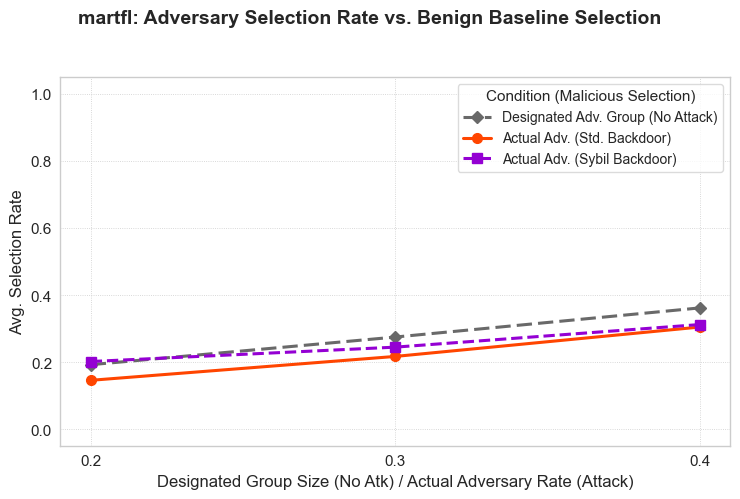

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed by Cell 1.

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_mal_select = summary_df_avg.copy()
    
    # Assuming AGGREGATION_METHOD is constant or you want to plot for a specific one.
    # If multiple, you might need to filter. For this example, taking the first one.
    aggregation_methods_present = plot_data_mal_select['AGGREGATION_METHOD'].unique()
    current_aggregation_method = aggregation_methods_present[0] if len(aggregation_methods_present) > 0 else "UnknownMethod"
    if len(aggregation_methods_present) > 1:
        print(f"Warning (Malicious Selection Plot): Multiple aggregation methods found. Plotting for '{current_aggregation_method}'. Filter if needed.")
        plot_data_mal_select = plot_data_mal_select[plot_data_mal_select['AGGREGATION_METHOD'] == current_aggregation_method]

    # Define required columns
    baseline_cols_map = {
        0.1: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.1',
        0.2: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.2',
        0.3: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.3',
        0.4: 'NO_ATTACK_DESIG_MAL_SEL_RATE_0.4'
    }
    actual_mal_select_col = 'AVG_ADVERSARY_SELECTION_RATE'
    
    # Check if all necessary columns exist
    missing_baseline_cols = [col for col in baseline_cols_map.values() if col not in plot_data_mal_select.columns]
    if actual_mal_select_col not in plot_data_mal_select.columns:
        missing_cols_error = f"Error: Column '{actual_mal_select_col}' not found. "
        if missing_baseline_cols:
            missing_cols_error += f"Additionally, baseline columns missing: {', '.join(missing_baseline_cols)}."
        print(missing_cols_error + " Cannot create plot.")
        # Set to empty to skip plotting
        plot_data_mal_select = pd.DataFrame() 
    elif missing_baseline_cols:
        print(f"Warning (Malicious Selection Plot): Some baseline columns missing: {', '.join(missing_baseline_cols)}. Baseline plot might be incomplete.")


    # Proceed only if we have the actual malicious selection rate column
    if not plot_data_mal_select.empty and actual_mal_select_col in plot_data_mal_select.columns:
        # Drop rows if the AVG_ADVERSARY_SELECTION_RATE is NaN for attack data,
        # or if ALL relevant NO_ATTACK_DESIG_MAL_SEL_RATE_X.X are NaN for No Attack data.
        
        # For attack data:
        attack_data_check = plot_data_mal_select[plot_data_mal_select['ATTACK_METHOD'] == 'Backdoor']
        if not attack_data_check.empty:
            plot_data_mal_select.loc[plot_data_mal_select['ATTACK_METHOD'] == 'Backdoor'] = \
                attack_data_check.dropna(subset=[actual_mal_select_col])
        
        # For no attack data (more complex as we use multiple baseline columns)
        # If a "No Attack" row has NaNs in ALL its NO_ATTACK_DESIG_MAL_SEL_RATE_X.X columns, it's not useful
        no_attack_rows = plot_data_mal_select['ATTACK_METHOD'] == 'No Attack'
        baseline_col_names_in_df = [col for col in baseline_cols_map.values() if col in plot_data_mal_select.columns]
        if baseline_col_names_in_df: # Only if some baseline columns exist
             plot_data_mal_select = plot_data_mal_select[~(no_attack_rows & plot_data_mal_select[baseline_col_names_in_df].isna().all(axis=1))]


        # 1. Prepare "No Attack - Designated Group" Baseline Data
        no_attack_runs = plot_data_mal_select[plot_data_mal_select['ATTACK_METHOD'] == 'No Attack'].copy()
        baseline_points = {} 
        if not no_attack_runs.empty:
            for adv_r_key, col_name in baseline_cols_map.items():
                if col_name in no_attack_runs.columns:
                    # Average over other variations (e.g. IS_SYBIL for "No Attack" runs)
                    mean_rate = no_attack_runs[col_name].mean() 
                    if pd.notna(mean_rate):
                        baseline_points[adv_r_key] = mean_rate
        del baseline_points[0.1 ]
        baseline_series_for_plot = pd.Series(baseline_points).sort_index()
        if baseline_series_for_plot.empty and not no_attack_runs.empty:
            print("Warning: Baseline series for 'No Attack' is empty after processing. Check NO_ATTACK_DESIG_MAL_SEL_RATE_X.X columns.")


        # 2. Prepare "Backdoor Attack" Data (Actual Malicious Selection Rate)
        # X-axis values for the attack lines should match the keys/index of baseline_series_for_plot
        adv_rates_for_attack_lines = baseline_series_for_plot.index.tolist() if not baseline_series_for_plot.empty else [0.2, 0.3, 0.4]

        backdoor_attack_data = plot_data_mal_select[
            (plot_data_mal_select['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_mal_select['ADV_RATE'].isin(adv_rates_for_attack_lines))
        ].copy()

        actual_mal_select_by_sybil = pd.DataFrame() # Initialize
        if not backdoor_attack_data.empty:
            actual_mal_select_by_sybil = backdoor_attack_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[actual_mal_select_col].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        else:
            print("Warning (Malicious Selection Plot): No 'Backdoor' attack data for plotting.")


        # --- Plotting ---
        if not actual_mal_select_by_sybil.empty or not baseline_series_for_plot.empty:
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11
            LINE_WIDTH = 2.2; MARKER_SIZE = 7

            fig, ax = plt.subplots(figsize=(7.5, 5.0))

            color_no_atk_baseline = 'dimgray'
            color_std_atk = 'orangered'    # Standard Backdoor (IS_SYBIL='False')
            color_mimic_atk = 'darkviolet' # Mimicry Backdoor (IS_SYBIL='mimic')

            linestyle_no_atk_baseline = (0, (5, 2)) # Loosely Dotted
            linestyle_std_atk = '-'         # Solid
            linestyle_mimic_atk = '--'      # Dashed

            marker_no_atk_baseline = 'D'
            marker_std_atk = 'o'
            marker_mimic_atk = 's'

            legend_elements = []

            # 1. Plot "No Attack - Designated Group Selection Rate" Baseline
            if not baseline_series_for_plot.empty:
                ax.plot(baseline_series_for_plot.index, baseline_series_for_plot.values,
                        color=color_no_atk_baseline, linestyle=linestyle_no_atk_baseline,
                        marker=marker_no_atk_baseline, linewidth=LINE_WIDTH, markersize=MARKER_SIZE-1)
                legend_elements.append(Line2D([0],[0], color=color_no_atk_baseline, linestyle=linestyle_no_atk_baseline,
                                              marker=marker_no_atk_baseline, markersize=MARKER_SIZE-1, lw=LINE_WIDTH,
                                              label='Designated Adv. Group (No Attack)'))
            else:
                print("No baseline data to plot for 'No Attack - Designated Group'.")


            # 2. Plot Actual Malicious Selection Rate for Standard Backdoor (IS_SYBIL='False')
            if not actual_mal_select_by_sybil.empty:
                data_std_backdoor = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'False']
                if not data_std_backdoor.empty:
                    ax.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor[actual_mal_select_col],
                            color=color_std_atk, linestyle=linestyle_std_atk, marker=marker_std_atk,
                            linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements.append(Line2D([0],[0], color=color_std_atk, linestyle=linestyle_std_atk,
                                                  marker=marker_std_atk, markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label='Actual Adv. (Std. Backdoor)'))
                else:
                    print("No data for Standard Backdoor (IS_SYBIL='False') line.")


            # 3. Plot Actual Malicious Selection Rate for Mimicry Backdoor (IS_SYBIL='mimic')
                data_mimic_backdoor = actual_mal_select_by_sybil[actual_mal_select_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic_backdoor.empty:
                    ax.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor[actual_mal_select_col],
                            color=color_mimic_atk, linestyle=linestyle_mimic_atk, marker=marker_mimic_atk,
                            linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements.append(Line2D([0],[0], color=color_mimic_atk, linestyle=linestyle_mimic_atk,
                                                  marker=marker_mimic_atk, markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label='Actual Adv. (Sybil Backdoor)'))
                else:
                    print("No data for Mimicry Backdoor (IS_SYBIL='mimic') line.")


            ax.set_xlabel('Designated Group Size (No Atk) / Actual Adversary Rate (Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Avg. Selection Rate', fontsize=AXIS_LABEL_FONT_SIZE) # Simplified Y Label
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            ax.set_ylim(-0.05, 1.05)

            # X-axis ticks should be consistent for all lines (0.1, 0.2, 0.3, 0.4)
            # Use the x-values from the baseline plot as the reference for ticks
            plot_xticks = baseline_series_for_plot.index.tolist() if not baseline_series_for_plot.empty else adv_rates_to_plot_on_x
            if plot_xticks:
                 ax.set_xticks(ticks=plot_xticks)
                 ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks])
            
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements:
                ax.legend(handles=legend_elements, title='Condition (Malicious Selection)',
                          fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_TITLE_FONT_SIZE,
                          loc='best', frameon=True, edgecolor='lightgray')

            fig.suptitle(f'{current_aggregation_method}: Adversary Selection Rate vs. Benign Baseline Selection',
                         fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Not enough data to plot Malicious Selection Rates after all filtering and preparation.")
else:
    print("DataFrame 'summary_df_avg' is not available (empty or not loaded). Skipping Malicious Selection Rate plot.")

'AVG_COST_PER_ROUND_BENIGN' or 'AVG_COST_PER_ROUND_MALICIOUS' not found. Will attempt to derive them.
Derived cost composition columns.


<Figure size 1000x600 with 0 Axes>

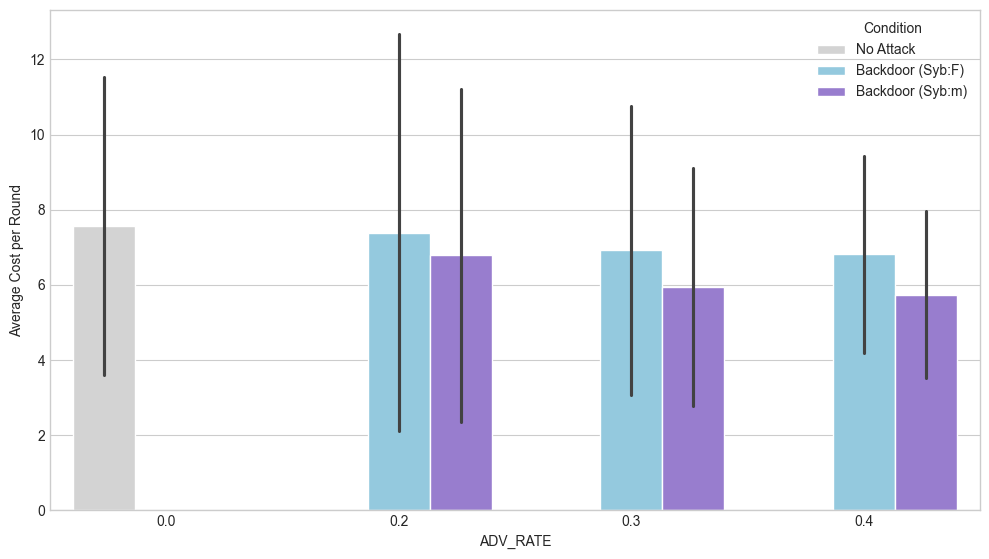

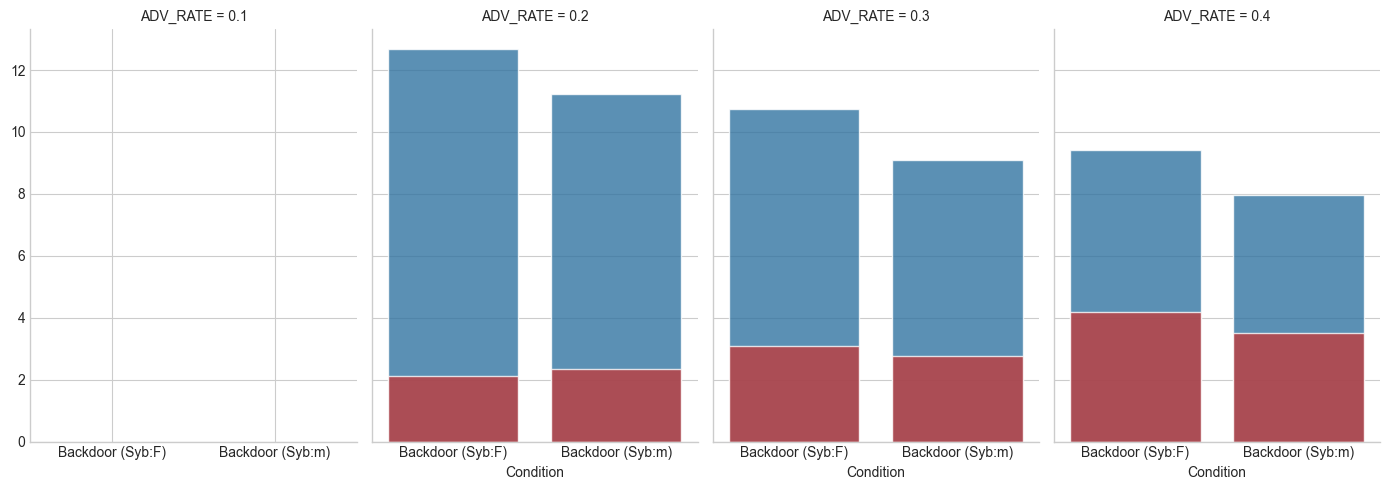

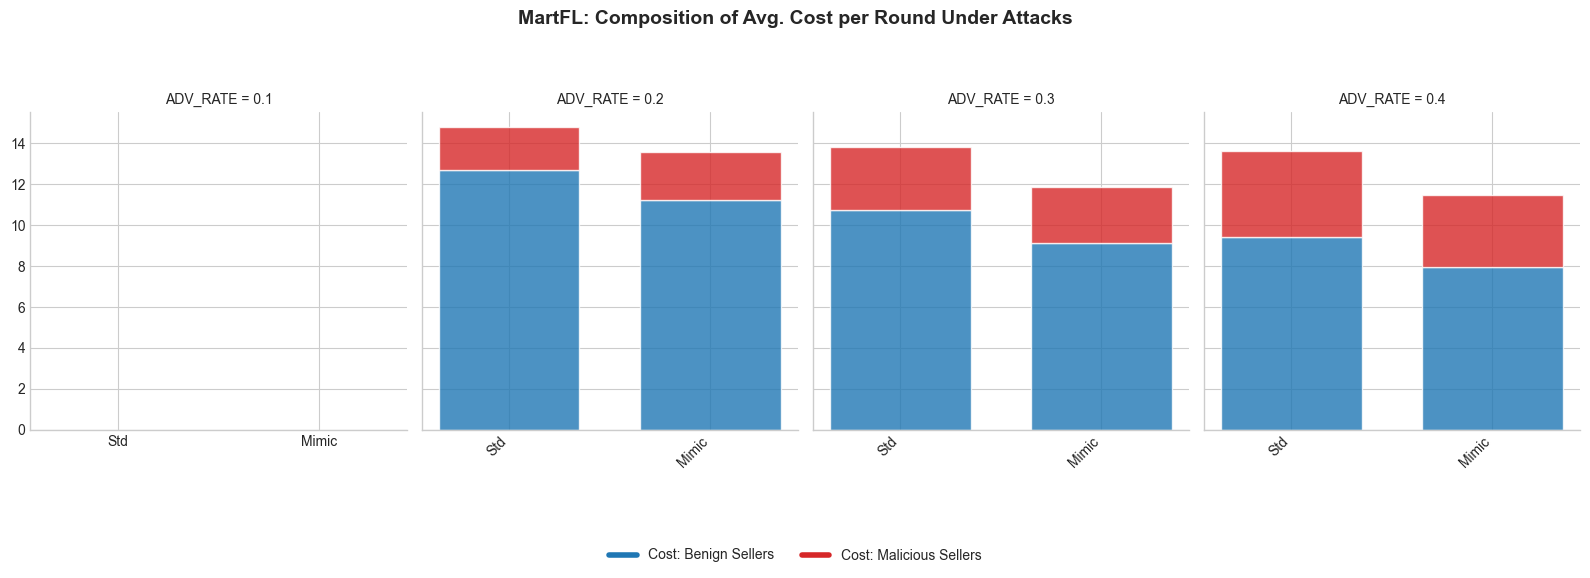

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D # Not strictly needed for bar, but good practice

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.
# It requires 'AVG_COST_PER_ROUND_BENIGN' and 'AVG_COST_PER_ROUND_MALICIOUS'
# (or 'AVG_COST_PER_ROUND' and 'AVG_ADVERSARY_SELECTION_RATE' to derive them).

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_cost_comp = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    # Check/Derive cost composition columns
    cost_benign_col = 'AVG_COST_PER_ROUND_BENIGN'
    cost_mal_col = 'AVG_COST_PER_ROUND_MALICIOUS'

    if not (cost_benign_col in plot_data_cost_comp.columns and cost_mal_col in plot_data_cost_comp.columns):
        print(f"'{cost_benign_col}' or '{cost_mal_col}' not found. Will attempt to derive them.")
        if 'AVG_COST_PER_ROUND' in plot_data_cost_comp.columns and 'AVG_ADVERSARY_SELECTION_RATE' in plot_data_cost_comp.columns:
            # Ensure numeric, already done in Cell 1 if listed in FLOAT_PRECISIONS
            plot_data_cost_comp[cost_mal_col] = plot_data_cost_comp['AVG_COST_PER_ROUND'] * plot_data_cost_comp['AVG_ADVERSARY_SELECTION_RATE']
            plot_data_cost_comp[cost_benign_col] = plot_data_cost_comp['AVG_COST_PER_ROUND'] * (1 - plot_data_cost_comp['AVG_ADVERSARY_SELECTION_RATE'])
            print("Derived cost composition columns.")
        else:
            print(f"Error: Cannot derive cost composition. Missing 'AVG_COST_PER_ROUND' or 'AVG_ADVERSARY_SELECTION_RATE'.")
            plot_data_cost_comp = pd.DataFrame() # Stop plotting

    if not plot_data_cost_comp.empty:
        # Ensure derived columns are also numeric (might be redundant if source cols were preprocessed)
        plot_data_cost_comp[cost_benign_col] = pd.to_numeric(plot_data_cost_comp[cost_benign_col], errors='coerce')
        plot_data_cost_comp[cost_mal_col] = pd.to_numeric(plot_data_cost_comp[cost_mal_col], errors='coerce')
        plot_data_cost_comp.dropna(subset=[cost_benign_col, cost_mal_col], how='any', inplace=True)


        # Prepare data for grouped bar chart
        # We want to compare No Attack, Backdoor (Std), Backdoor (Mimic)
        # X-axis will be ADV_RATE (0.0 for No Attack, 0.1-0.4 for attacks)
        adv_rates_for_bars = [0.0, 0.1, 0.2, 0.3, 0.4] # ADV_RATE=0.0 will represent "No Attack"

        data_for_bars = plot_data_cost_comp[
            (plot_data_cost_comp['ATTACK_METHOD'] == 'No Attack') | # ADV_RATE for these is 0.0
            ((plot_data_cost_comp['ATTACK_METHOD'] == 'Backdoor') & plot_data_cost_comp['ADV_RATE'].isin(adv_rates_for_bars))
        ].copy()

        # For "No Attack", IS_SYBIL might vary but cost comp should be similar. We can average it.
        # For "Backdoor", we need to distinguish IS_SYBIL.
        
        # Create a combined 'Condition' column for grouping in the bar plot
        def get_condition(row):
            if row['ATTACK_METHOD'] == 'No Attack':
                return 'No Attack'
            elif row['ATTACK_METHOD'] == 'Backdoor':
                return f"Backdoor (Syb:{row['IS_SYBIL'][0]})" # Shorten Sybil Label
            return 'Other'
        data_for_bars['Condition'] = data_for_bars.apply(get_condition, axis=1)

        # Group by ADV_RATE and Condition to get average costs
        grouped_costs = data_for_bars.groupby(['ADV_RATE', 'Condition'], as_index=False)[
            [cost_benign_col, cost_mal_col]
        ].mean()
        
        # We need to pivot or melt for seaborn's barplot if stacking or grouping by cost type
        melted_costs = pd.melt(grouped_costs,
                               id_vars=['ADV_RATE', 'Condition'],
                               value_vars=[cost_benign_col, cost_mal_col],
                               var_name='Cost Type', value_name='Average Cost per Round')
        
        # Rename Cost Type for legend
        melted_costs['Cost Type'] = melted_costs['Cost Type'].replace({
            cost_benign_col: 'Benign Seller Cost',
            cost_mal_col: 'Malicious Seller Cost'
        })


        # --- Plotting Cost Composition Bar Chart ---
        if not melted_costs.empty:
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11

            plt.figure(figsize=(10, 6)) # Wider for grouped bars

            # Grouped bar chart: x=ADV_RATE, hue=Condition, y=Average Cost per Round, bars for Cost Type
            # This might be too complex. Let's try STACKED bar or GROUPED by Condition.

            # Option: Stacked Bar Chart for each ADV_RATE and Condition
            # We need ADV_RATE on x, and then bars for each Condition, stacked by Benign/Malicious cost.
            # This requires pivoting 'Condition' to columns for seaborn's default stacked bar.
            # Or, iterate and plot manually.

            # Let's do a grouped bar chart: x='Condition', hue='Cost Type', faceted by 'ADV_RATE' or vice-versa
            # Simpler: x='ADV_RATE', hue='Cost Type', separate bars for each 'Condition'

            # For paper, often better to have fewer groups on x-axis if using hue.
            # Let's plot ADV_RATE on X, and then group bars by 'Condition', with 'Cost Type' as hue for stacking.

            # Re-pivot for stacking: index=ADV_RATE, columns=Condition, then melt Cost_Type
            pivoted_for_plot = melted_costs.pivot_table(
                index=['ADV_RATE', 'Condition'], 
                columns='Cost Type', 
                values='Average Cost per Round'
            ).reset_index()
            
            # Order for plotting
            condition_order = ['No Attack'] + \
                              [f'Backdoor (Syb:{s[0]})' for s in sorted(plot_data_cost_comp[plot_data_cost_comp['ATTACK_METHOD']=='Backdoor']['IS_SYBIL'].dropna().unique())]


            # We need to create positions for grouped bars
            adv_rate_categories = sorted(pivoted_for_plot['ADV_RATE'].unique())
            condition_categories = [c for c in condition_order if c in pivoted_for_plot['Condition'].unique()]
            
            n_conditions = len(condition_categories)
            bar_width = 0.8 / n_conditions # Width of each individual bar group
            index = np.arange(len(adv_rate_categories)) # x-positions for ADV_RATE groups

            fig_bar, ax_bar = plt.subplots(figsize=(12, 6.5))

            for i, condition in enumerate(condition_categories):
                condition_data = pivoted_for_plot[pivoted_for_plot['Condition'] == condition].set_index('ADV_RATE')
                # Align data with all adv_rate_categories, filling missing with 0 for plotting
                condition_data = condition_data.reindex(adv_rate_categories, fill_value=0)

                # Positions for bars of this condition
                bar_positions = index - (bar_width * (n_conditions -1) / 2) + (i * bar_width)
                
                # Stacked bars for Benign and Malicious cost
                ax_bar.bar(bar_positions, condition_data['Benign Seller Cost'], width=bar_width*0.9, label=f'{condition} - Benign' if i==0 else None, color='tab:blue', alpha=0.8)
                ax_bar.bar(bar_positions, condition_data['Malicious Seller Cost'], bottom=condition_data['Benign Seller Cost'], width=bar_width*0.9, label=f'{condition} - Malicious' if i==0 else None, color='tab:red', alpha=0.8)
            
            # Create custom legend handles for the stacked components
            legend_elements_bar = [
                Line2D([0], [0], color='tab:blue', lw=4, label='Cost from Benign Sellers'),
                Line2D([0], [0], color='tab:red', lw=4, label='Cost from Malicious Sellers')
            ]
            # Add labels for conditions if not too many
            # For this setup, the x-tick groups represent the conditions.

            ax_bar.set_xlabel('Adversary Rate & Attack Condition', fontsize=AXIS_LABEL_FONT_SIZE)
            ax_bar.set_ylabel('Avg. Cost per Round (Selections)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax_bar.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)
            
            # Set X-ticks to be the ADV_RATE categories, and then group labels under them
            ax_bar.set_xticks(index)
            ax_bar.set_xticklabels([f"ADV_RATE={adv:.1f}" for adv in adv_rate_categories], fontsize=TICK_LABEL_FONT_SIZE-1)

            # Add secondary x-axis labels for conditions below each ADV_RATE group (can be tricky)
            # For simplicity, we rely on legend or distinct bar groups.
            # Or, if fewer ADV_RATEs, could make x-axis categorical with "ADV_RATE @ Condition"

            # More direct: x = Condition, hue = Cost Type, facet by ADV_RATE (if few ADV_RATEs)
            # Or: x = ADV_RATE, hue = Condition, stacked bar for Cost Type (Benign/Malicious)
            # Let's re-try with seaborn barplot for easier grouping if data is melted right

            # Simpler approach: Grouped bars, not stacked, side-by-side for Benign/Malicious
            fig_bar_grouped, ax_bar_grouped = plt.subplots(figsize=(12, 6.5))
            sns.barplot(data=melted_costs, x='ADV_RATE', y='Average Cost per Round', hue='Condition',
                        palette={'No Attack': 'lightgray',
                                 f'Backdoor (Syb:F)': 'skyblue', # Syb:F for False
                                 f'Backdoor (Syb:m)': 'mediumpurple'}, # Syb:m for mimic
                        ax=ax_bar_grouped,
                        # Errorbar=None if using summary_df_avg
                        )
            # This plots total cost for each condition. We need to show Benign AND Malicious for each.
            # The previous manual stacking is better for showing composition.

            # Let's stick to manual stacking but improve x-axis for clarity.
            # Create a new figure for the final manual stacking approach
            plt.close(fig_bar) # Close the previous attempt
            fig_bar_stacked, ax_bar_stacked = plt.subplots(figsize=(10, 6))

            bar_group_labels = []
            all_bar_positions = []
            group_width = 0.8 # Width for all bars related to one ADV_RATE
            num_adv_rates = len(adv_rate_categories)
            
            current_pos = 0
            for adv_idx, adv in enumerate(adv_rate_categories):
                adv_rate_group_center = adv_idx * (n_conditions + 1) * (bar_width / n_conditions) # Center of group for this adv_rate
                
                for cond_idx, condition in enumerate(condition_categories):
                    condition_data_at_adv = pivoted_for_plot[
                        (pivoted_for_plot['Condition'] == condition) &
                        (pivoted_for_plot['ADV_RATE'] == adv)
                    ]
                    if condition_data_at_adv.empty: continue

                    benign_cost = condition_data_at_adv['Benign Seller Cost'].iloc[0]
                    mal_cost = condition_data_at_adv['Malicious Seller Cost'].iloc[0]
                    
                    bar_pos = adv_rate_group_center + (cond_idx - (n_conditions-1)/2) * (bar_width/n_conditions*1.1) # Spread bars within group
                    
                    ax_bar_stacked.bar(bar_pos, benign_cost, width=bar_width/n_conditions*0.9, color='tab:blue', alpha=0.7, label='_nolegend_')
                    ax_bar_stacked.bar(bar_pos, mal_cost, bottom=benign_cost, width=bar_width/n_conditions*0.9, color='tab:red', alpha=0.7, label='_nolegend_')
                    
                    if adv_idx == 0 : # Add condition label only once for clarity
                        bar_group_labels.append((bar_pos, condition))
                    all_bar_positions.append(bar_pos)


            ax_bar_stacked.set_ylabel('Avg. Cost per Round (Selections)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax_bar_stacked.tick_params(axis='y', labelsize=TICK_LABEL_FONT_SIZE)

            # X-axis: Primary ticks for ADV_RATE, secondary for Condition (complex to make nice)
            # Simpler: Use text annotations or a multi-level index if plotting library supports easily.
            # For now, position ticks at the center of each ADV_RATE group.
            adv_rate_group_centers = [idx * (n_conditions + 1) * (bar_width / n_conditions) for idx in range(num_adv_rates)]
            ax_bar_stacked.set_xticks(adv_rate_group_centers)
            ax_bar_stacked.set_xticklabels([f"ADV_RATE\n{adv:.1f}" for adv in adv_rate_categories], fontsize=TICK_LABEL_FONT_SIZE-1)
            ax_bar_stacked.set_xlabel('Attack Scenario', fontsize=AXIS_LABEL_FONT_SIZE) # General label

            # Add text for conditions under each group (if needed and not too cluttered)
            # For now, legend will distinguish conditions. The bar groups are per ADV_RATE.
            # We need a better way to show conditions on X or use FacetGrid.

            # Given the complexity, let's simplify: Facet by ADV_RATE, X=Condition, Stacked Bar for Benign/Mal
            if not melted_costs.empty:
                g_bar = sns.FacetGrid(melted_costs, col="ADV_RATE", height=5, aspect=0.7, col_order=adv_rates_to_plot_on_x)
                g_bar.map_dataframe(lambda data, color: sns.barplot(data=data, x="Condition", y="Average Cost per Round", hue="Cost Type",
                                                                  palette={"Benign Seller Cost": "tab:blue", "Malicious Seller Cost": "tab:red"},
                                                                  dodge=False, alpha=0.8)) # dodge=False for stacking
                # This requires a bit more work to make sns.barplot stack. Usually it groups.
                # Manual stacking per facet is more reliable.
                
                # Let's retry manual stacking but with facets for ADV_RATE
                plt.close(fig_bar_stacked) # Close previous attempt
                
                if not pivoted_for_plot.empty:
                    g_stacked_bar = sns.FacetGrid(pivoted_for_plot, col="ADV_RATE", col_order=adv_rates_to_plot_on_x,
                                                  height=5, aspect=0.8, sharey=True)
                    
                    def stacked_bar(data, **kwargs):
                        ax_facet = plt.gca()
                        conditions_in_facet = data['Condition'].unique()
                        x_pos = np.arange(len(conditions_in_facet))
                        
                        bottom_val = np.zeros(len(conditions_in_facet))
                        if 'Benign Seller Cost' in data.columns:
                            benign_bars = ax_facet.bar(x_pos, data['Benign Seller Cost'], width=0.7, color='tab:blue', alpha=0.8, label='_nolegend_')
                            bottom_val += data['Benign Seller Cost'].fillna(0).values
                        if 'Malicious Seller Cost' in data.columns:
                            mal_bars = ax_facet.bar(x_pos, data['Malicious Seller Cost'], bottom=bottom_val, width=0.7, color='tab:red', alpha=0.8, label='_nolegend_')
                        
                        ax_facet.set_xticks(x_pos)
                        ax_facet.set_xticklabels([c.replace("Backdoor (Syb:F)", "Std").replace("Backdoor (Syb:m)", "Mimic").replace("No Attack", "NoAtk") 
                                                  for c in conditions_in_facet], rotation=45, ha="right", fontsize=TICK_LABEL_FONT_SIZE-1)
                        ax_facet.set_xlabel("") # Remove individual x-labels, FacetGrid col title is enough
                        if data["ADV_RATE"].iloc[0] == adv_rates_to_plot_on_x[0]: # Only for first facet
                             ax_facet.set_ylabel('Avg. Cost per Round', fontsize=AXIS_LABEL_FONT_SIZE)
                        else:
                             ax_facet.set_ylabel("")


                    g_stacked_bar.map_dataframe(stacked_bar)
                    g_stacked_bar.set_titles(col_template="ADV_RATE = {col_name}")
                    g_stacked_bar.fig.suptitle(f'{current_aggregation_method}: Composition of Avg. Cost per Round Under Attacks',
                                             fontsize=TITLE_FONT_SIZE, y=1.03, fontweight='bold')
                    
                    # Add a single legend for the entire figure
                    handles_bar = [Line2D([0], [0], color='tab:blue', lw=4), Line2D([0], [0], color='tab:red', lw=4)]
                    labels_bar = ['Cost: Benign Sellers', 'Cost: Malicious Sellers']
                    g_stacked_bar.fig.legend(handles=handles_bar, labels=labels_bar,
                                           loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2,
                                           fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_TITLE_FONT_SIZE, frameon=False)
                    
                    g_stacked_bar.fig.tight_layout(rect=[0, 0.08, 1, 0.96])
                    plt.show()
                else:
                    print("Pivoted data for stacked bar is empty.")


        else:
            print("Melted cost data is empty. Cannot plot cost composition.")
else:
    print("DataFrame 'summary_df_avg' is not available for Cost Composition plot.")